# Wavelet Significance Testing Methods Development

This is the development notebook of the significance testing using wavelet analysis. I am using this notebook to:

1) Guide the implementation of biwavelet coherence, cross-wavelet transforms, and phase angle.

2) Guide the significance testing with the above methods. There are two general approaches to hypothesis testing/significance detection.

- Monte-Carlo simulations, which is largely what is presented in TC98, especially for wavelet coherence. 

- Analytic functions for certain classes of null hypotheses (specifically for red noise with CWT and for white noise with coherence). These analytic functions are an innovation from G07 and G08.

Additionally, each general approach will be compared to examples in literature to verify that the pycwt library and my additions to it all function in a consistent way.

Each reference is referred to by the initial of the first author and year (e.g., Ge (2008) will be G08).

### References
Allen, M. R., and L. A. Smith (1996), Monte Carlo SSA: Detecting Irregular Oscillations in the Presence of Colored Noise, J. Clim., 9, 3373–3403, doi:10.1175/1520-0442(1996)009<3373:MCSDIO>2.0.CO;2.

Chavez, M., and B. Cazelles (2019), Detecting dynamic spatial correlation patterns with generalized wavelet coherence and non-stationary surrogate data, Sci. Rep., 9(April), 1–9, doi:10.1038/s41598-019-43571-2.

Ge, Z. (2007), Significance tests for the wavelet power and the wavelet power spectrum, Ann. Geophys., 25(11), 2259–2269, doi:10.5194/angeo-25-2259-2007.

Ge, Z. (2008), Significance tests for the wavelet cross spectrum and wavelet linear coherence, Ann. Geophys., 26(2007), 3819–3829, doi:10.5194/angeo-26-3819-2008.

Gilman, D. L., F. J. Fuglister, and J. J. M. Mitchell (1962), On the Power Spectrum of “Red Noise,” J. Atmos. Sci., 20, 182–184, doi:1520-0469(1963)020<0182:OTPSON>2.0.CO;2.

Liu, Y., S. X. Liang, and R. H. Weisberg (2007), Rectification of the Bias in the Wavelet Power Spectrum, J. Atmos. Ocean. Technol., 24, 2093–2102, doi:10.1175/2007JTECHO511.1.

Torrence, C., and G. P. Compo (1998), A Practical Guide to Wavelet Analysis, Bull. Am. Meteorol. Soc., 79(1), 61–78, doi:https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2.

Veleda, D., R. Montagne, and M. Araujo (2012), Cross-Wavelet Bias Corrected by Normalizing Scales, J. Atmos. Ocean. Technol., 29, 1401–1408, doi:10.1175/JTECH-D-11-00140.1.

In [1]:
# math manipulation
import numpy as np
import scipy

# OS interaction
import sys
# Add the other files from these helper functions
sys.path.append('../helper_functions')
sys.path.append('../figures')

# import plotting|
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pycwt

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt
# My local colorbline friendly colormap generator
import SRON

# Format plots

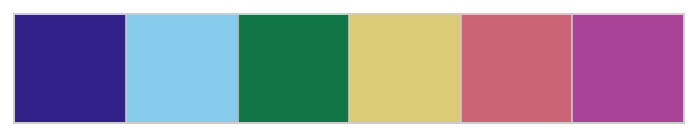

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'
mpl.rc("savefig", dpi=150)

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
flatui = SRON.SRON(6)
sns.set_palette(sns.color_palette(flatui))
sns.palplot(sns.color_palette(flatui))

# Wavelet significance testing

There are two types of significance tests: 

1) analytically derived thresholds

2) Monte-Carlo simulations

Most recent, high-impact publications using wavelets have used Monte-Carlo simulations. The analytically-derived thresholds rely on a known noise property. For CWT that known noise is usually white noise or red noise. For wavelet coherence, there have been only a couple attempts to derive analytic expressions (i.e., Ge 2008). As the implementation and innovation of wavelet applications has outpaced the analytic understanding, my impression is that the consequence has been to turn increasingly to Monte-Carlo derived significance tests. Note that the field has not really progressed past the original Monte-Carlo simulations or approximations of Monte-Carlo simulations from TC98.

In this notebook I try to provide some documentation of how I approached this general problem.

For __biwavelet coherence__, I implement the following tests: 

- Analytic expression from G08, in which the expected spectra from two white noise gaussian processes are convolved. They develop three tests: wavelet linear coherence, phase angle, and the cross wavelet transform. Since the XWT was not scale rectified I will not rely on this test and will instead focus on the coherence test.

- Monte-Carlo simulations. Shown below, the pycwt package appears to have a couple mistakes in the Monte-Carlo tests. I explore a more general approach and find, somewhat surprisingly, that the underlying noise shape (be it white or red) does not effect the coherence significance threshold. That's a wild result! It also makes me a bit skeptical. The biggest issue is accounting for edge effects where only a limited number of samples occur outside the COI, i.e. at the largest wavelengths where it can be hard to make the Monte-Carlo simulations converge.

For __continuous wavelet transforms__, I will implement the following tests:

- Analytically derived signficance tests for CWT following TC98 for a red noise process described as an AR(1) Markov chain.

- Monte-Carlo simulations. Just to verify the significance spectra as a reassurance that everything is functioning correctly.


# Biwavelet Coherence

## Existing Methods: pycwt Monte-Carlo signficance testing

This is a painfully slow process. Since it shouldn't materially change, we can just keep track of this one realization. The slowness comes from the step "constructing the wavelet coherence coefficient" not the CWT or coherence calcualtion. It isn't clear to me what this step is accomplishing.

Here are the results for a red noise process with a lag-1 coefficient of 0.8. However, later I will demonstrate that this is not actually a red noise process.

```
sig_testing = False
if sig_testing:
    sig = wavelet.wct_significance(0.8, 0.8, dt=dx, dj=dj, s0=s0, J=np.int(J),
                           significance_level=0.95,
                           wavelet=mother, cache=False)

dj = 1/12 # Twelve sub-octaves per octaves
s0 = 2 * dx # Starting scale, here 6 months
J = 8 / dj # Seven powers of two with dj sub-octaves

sig = np.array([0.81401639, 0.78345545, 0.75279858, 0.7226635 , 0.69350109,
       0.66652241, 0.64147332, 0.62004038, 0.60550525, 0.59619792,
       0.59208776, 0.59072181, 0.58914302, 0.58921696, 0.58864916,
       0.58791544, 0.58771774, 0.58681882, 0.58635698, 0.58501009,
       0.58401166, 0.5835097 , 0.58349667, 0.58467324, 0.585693  ,
       0.58655234, 0.5863466 , 0.58624939, 0.58686015, 0.58659448,
       0.58678618, 0.58726164, 0.58603571, 0.58563789, 0.58549894,
       0.58386848, 0.58320097, 0.58234965, 0.58292099, 0.58314303,
       0.58221027, 0.58186458, 0.58228747, 0.58382872, 0.58571046,
       0.58604665, 0.58597749, 0.58591532, 0.58626835, 0.58721651,
       0.58765012, 0.58995332, 0.58966892, 0.58934133, 0.58651515,
       0.58232936, 0.58114409, 0.58075262, 0.58063482, 0.58336237,
       0.5848144 , 0.58410801, 0.5826817 , 0.58313725, 0.58381667,
       0.58499733, 0.58684185, 0.58420528, 0.58095385, 0.58555905,
       0.58851972, 0.59066504, 0.59348441, 0.59728856, 0.60067726,
       0.60047013, 0.60054622, 0.59985914, 0.60139413, 0.60939136,
       0.61795857, 0.61604744, 0.62274909, 0.62588975, 0.62892926,
       0.63144272, 0.63280975, 0.62892239, 0.62442544, 0.62464069,
       0.62672532, 0.64305479, 0.66582609, 0.6909901 , 0.71090922,
       0.72671429,        nan])
```

Running the Monte-Carlo simulation for noise takes on the order of 20-30 minutes. It is slow. Note that I only do this for an approximately white noise process since the lag-1 coefficient has no effect.

In [3]:
# Significance testing for a Gaussian White Noise process
sig_testing_gwn = False
if sig_testing_gwn:
    octaves = [1 / 8, 10 / (1 / 8)]  
    
    dj = octaves[0] # Twelve sub-octaves per octaves
    s0 = 2 * (1 / 50) # Starting scale for the below example
    J = octaves[1] # Seven powers of two with dj sub-octaves
    
    # First two arguments are the lag1 coefficients for
    # the respective time series
    # The remaining arguments are the wavelet properties.
    
    # Note that this function has a bug that fails if using
    # AR1 = 0, so we add a small amount here that is negligible.
    sig_gwn = wavelet.wct_significance(
        0.0001,
        0.0001,
        dt=dx,
        dj=dj,
        s0=s0,
        J=np.int(J),
        significance_level=0.95,
        wavelet=mother,
        cache=False
    )
    
    print(sig_gwn)
    
else:
    sig_gwn = np.array(
    [
        0.99027064, 0.98728349, 0.98262321, 0.97512532, 0.96282878, 0.94329062,
         0.91390386, 0.87436915, 0.82778517, 0.7793001,  0.73219902, 0.68887213,
         0.65003053, 0.61612839, 0.59052566, 0.57659683, 0.57226818, 0.5715865,
         0.57178227, 0.57227633, 0.57262917, 0.57315678, 0.57390979, 0.57394476,
         0.57391972, 0.57230036, 0.57133566, 0.57066517, 0.57025429, 0.56949333,
         0.5698979,  0.57054771, 0.57040567, 0.56977401, 0.57163281, 0.57368067,
         0.57506448, 0.57642776, 0.57677148, 0.57629259, 0.57473184, 0.57648447,
         0.57899626, 0.5775913,  0.57819688, 0.57864842, 0.57606242, 0.57279131,
         0.57244671, 0.57487833, 0.57622399, 0.57420183, 0.57315187, 0.57254953,
         0.57228826, 0.57291127, 0.57500123, 0.57252937, 0.56919087, 0.57390038,
         0.57869708, 0.58481824, 0.58341717, 0.58026522, 0.57838561, 0.57446158,
         0.57537069, 0.57147072, 0.57222293, 0.58121804, 0.59233199, 0.59480722,
         0.6028008,  0.59683215, 0.59449467, 0.60143492, 0.60489128, 0.62054637,
         0.65018415, 0.68858563,        np.nan,
    ]
    )

## Existing Methods: Analytical expressions using G08 White noise stationarity tests

As most of the theoretical work on wavelets employs the Morlet wavelet, the following discussion will presume this wavelet.

From Ge 2008:

$$
D_{\alpha}(L_{xy}) = tanh^2 \left(s_{\alpha} \sqrt{\frac{2 \sqrt{\ln(\kappa)} f_c F_s}{mf}} \right)
$$

where $D_{\alpha}$ is the significance level of a wavelet linear coherence given by $L_{xy}$, $s_\alpha$ is the $1 - \alpha$ significance level in percentile, $\kappa$ is the decorrelation parameter, $f_c$ is undefined but somehow related to the conversion between fourier frequency and wavelet scale, $F_s$ is the sampling frequency ($\delta t$ is the sampling period, the inverse of the sampling frequency), $m$ is the number of data points, and $f$ is the (fourier?) frequency. 

### Detective work on what $f_c$ is:

This expression uses the equivalent fourier frequencies, not the wavelet scales. From TC98, Table 1 we have the following expression for converting between wavelet (time?) scale $s$ and fourier frequency.

$$
\lambda = \frac{4 \pi s}{\omega_0 + \sqrt{2 + \omega_0^2}}
$$

where $\lambda$ is the fourier wavelength and $\omega_0$ is the non-dimensional frequency. The Morlet wavelet is commonly employed with $\omega_0=6$. Note that other wavelets have different non-dimensional scales in their definition that are not frequency.


My suspicion is that equation 12 in G08 in which $f_c$ appears is an approximation of the above expression. To verify, we can convert the above expression into frequencies (instead of wavelengths).

Note that there are multiple notation differences between G08 and TC98. The dilation scale in TC98 is $s$ and in G08 is $a$. Here I hint at what I believe is the result by calling the converted wavelet scale to fourier scale $f_c$.

$$
f_c = \frac{(\omega_0 + \sqrt{2 + \omega_0^2})}{4 \pi a}
$$

Solving for $a$

$$
a = \frac{4 \pi}{f(\omega_0 + \sqrt{2 + \omega_0^2})}
$$

We can quickly compute this value using pycwt as this identify is built-in as a property of the mother wavelet. Note that I get the same result when doing this step manually.

In [4]:
mother = pycwt.Morlet(6.)
a = 1 / (mother.flambda())

print('a = {:0.3f} / f'.format(a))

a = 0.968 / f


And here is where my confusion is (and why I am being so careful on this step). In G08, this expression, which I am only inferring since it was never defined, is eq 12.

$$
a = \frac{f_c}{f} \approx \frac{0.9394}{f} 
$$

which is slightly different. Given that I understand the TC98 expression, that it is cleanly documented in the pycwt and the R biwavelet packages, and that G08 is not so clear in their definition I will continue using this value, which has the added benefit of being easily derived for any wavelet employed in pycwt. $f_c$ is the fourier mode conversion for each wavelet, defined in Table 1 of TC98 and in the `flambda` property of a pycwt wavelet object.

In [5]:
def wlc_gwn_sig(mother, m, f, F_s, s_a=None, kappa=None):
    '''
    mother - pycwt wavelet mother object. Needs to have `flambda` attribute.
    m - float, number of observations averaged together
    f - float, equivalent fourier frequencies of the wavelet
    F_S - float, sampling frequency
    s_a - float, percentile significance level. Default value is 0.05 (95%)
    kappa - float, decorrelation parameter. Default value is 5.
    '''

    if s_a is None:
        s_a = 0.95
    if kappa is None:
        kappa = 5
#     f_c = 1 / mother.flambda()
    # The above expression is correct but due to debugging I opt to use G08's
    # original approximation.
    f_c = 0.9394

    sig = np.tanh(s_a * np.sqrt((2 * np.sqrt(np.log(kappa)) * f_c * F_s) / (m * f) ) ) ** 2
    
    return sig

def wlc_gwn_approx_sig(m, f, F_s):
    '''
    Van Milligen et al., (1998) approximation of the statistical certainty level
    (exact level unknown) for wavelet coherency.
    
    INPUTS:
        m - float, number of data points in the window
        f - array, fourier frequencies of the wavelet
        F_s - float, sampling frequency
        
    OUTPUTS:
        sig - float, (95%?) significance, same size as f
    '''
    sig = 2 * np.sqrt(F_s / (m * f))
    
    return sig

# Test methods using toy data

This example data follows G08's and contains three different relationships between the `x` and `y` signals. 

1) In the first regime (t=700$\delta t$ to 900$\delta t$) the phase angle changes with `t`.

2) In the second regime (t=901$\delta t$ to 1100$\delta t$) there is a constant phase offset with `y` lagging `x`.

3) In the third regime (t=1101$\delta t$ to 1300$\delta t$) there is a constant phase offset with `y` leading `x`.

In [6]:
# Build the example function
datalen = 2000
t = np.arange(0, datalen)
sampling_f = 50
sampling_p = 1 / sampling_f
osc = 8

x = np.zeros(datalen) + np.random.normal(0, 1, size=datalen)
y = np.zeros(datalen) + np.random.normal(0, 1, size=datalen)

signal_noise = 5
A = (10 ** (signal_noise / 10)) ** (1 / 2)

n = slice(700, 1300)
x[n] = x[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p)

n = slice(700, 900)
y[n] = (
    y[n]
    + A * np.sin(
        2 * np.pi * osc * t[n] * sampling_p
        + (t[n] - t[700]) / (t[900] - t[700]) * 2 * np.pi
    )
)
n = slice(900, 1100)
y[n] = y[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p - 2 / 3 * np.pi)

n = slice(1100, 1300)
y[n] = y[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p + 2 / 3 * np.pi)

### Initial CWT exploration of this toy dataset

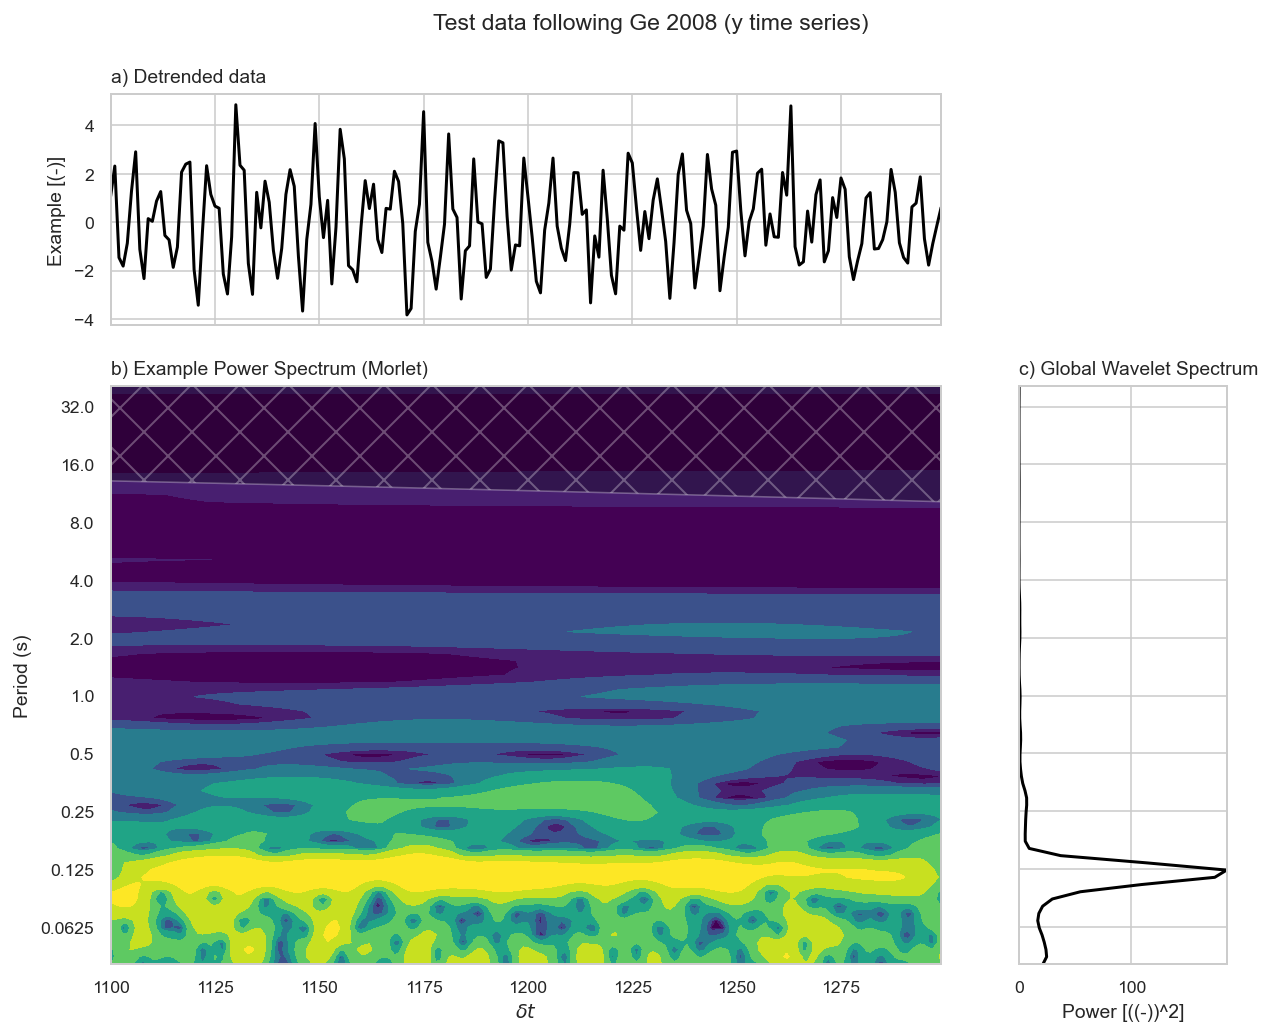

In [7]:
mother = pycwt.Morlet()
octaves = [1 / 8, 10 / (1 / 8)]  

(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
                                                    y, sampling_p, t, mother, scales_to_avg=None,
                                                    octaves=octaves,
                                                    glbl_power_var_scaling=False,
                                                    norm_kwargs={'standardize': False, 'detrend': False})

title = 'Test data following Ge 2008 (y time series)'
label = 'Example'
units = '(-)'
scale_units = 's'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': '$\delta t$'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm[n],
    x=t[n],
    dx=sampling_p,
    period=scales,
    power=power[:, n],
    coi=coi[n],
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False)

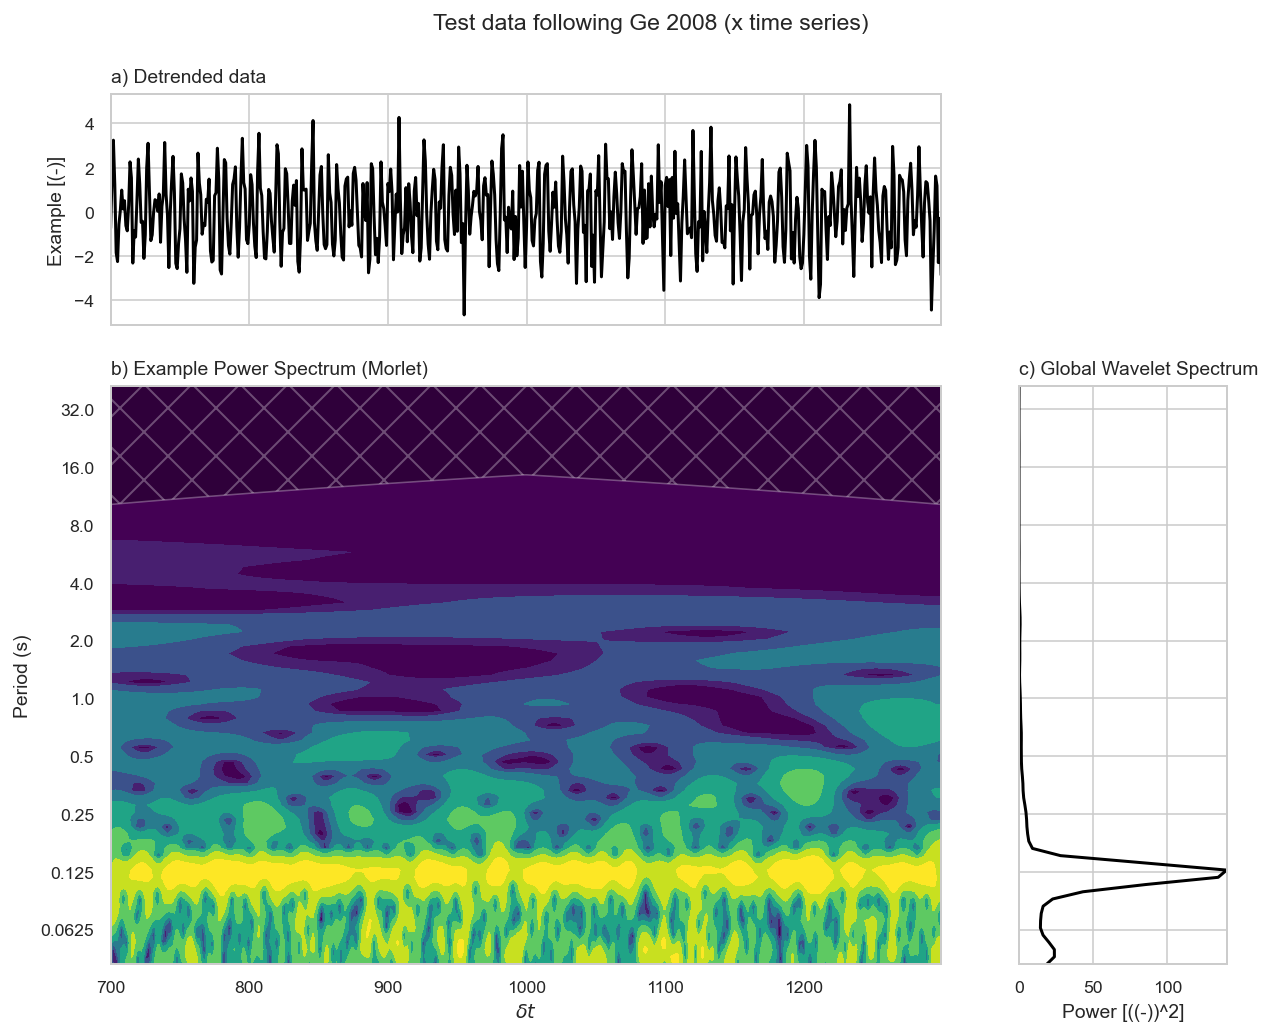

In [8]:
mother = pycwt.Morlet()
octaves = [1 / 8, 10 / (1 / 8)]  

(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
                                                    x, sampling_p, t, mother, scales_to_avg=None,
                                                    octaves=octaves,
                                                    glbl_power_var_scaling=False,
                                                    norm_kwargs={'standardize': False, 'detrend': False})

title = 'Test data following Ge 2008 (x time series)'
label = 'Example'
units = '(-)'
scale_units = 's'

n = slice(700, 1300)

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': '$\delta t$'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm[n],
    x=t[n],
    dx=sampling_p,
    period=period,
    power=power[:, n],
    coi=coi[n],
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False)

Note that these spectra do not agree with the results from G07 or G08. This is a result of an incorrect scaling of the spectra by $\delta t^2$ that is noted in an corregium. However, this is adding to my general skepticism of the published spectra in many of these studies...

### Now for the cross spectrum and coherence

In [9]:
octaves = [1 / 8, 10 / (1 / 8)]  
(WCT, aWCT, W12,
 W12_corr, period,
 coi_G08, angle, s1, s2) = cwt_stat.wavelet_coherent(
    x, y, sampling_p, octaves[0], 2 * sampling_p, octaves[1], mother, norm_kwargs={'detrend': False}
)

### Visualizing the biwavelet coherence of the three regimes

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


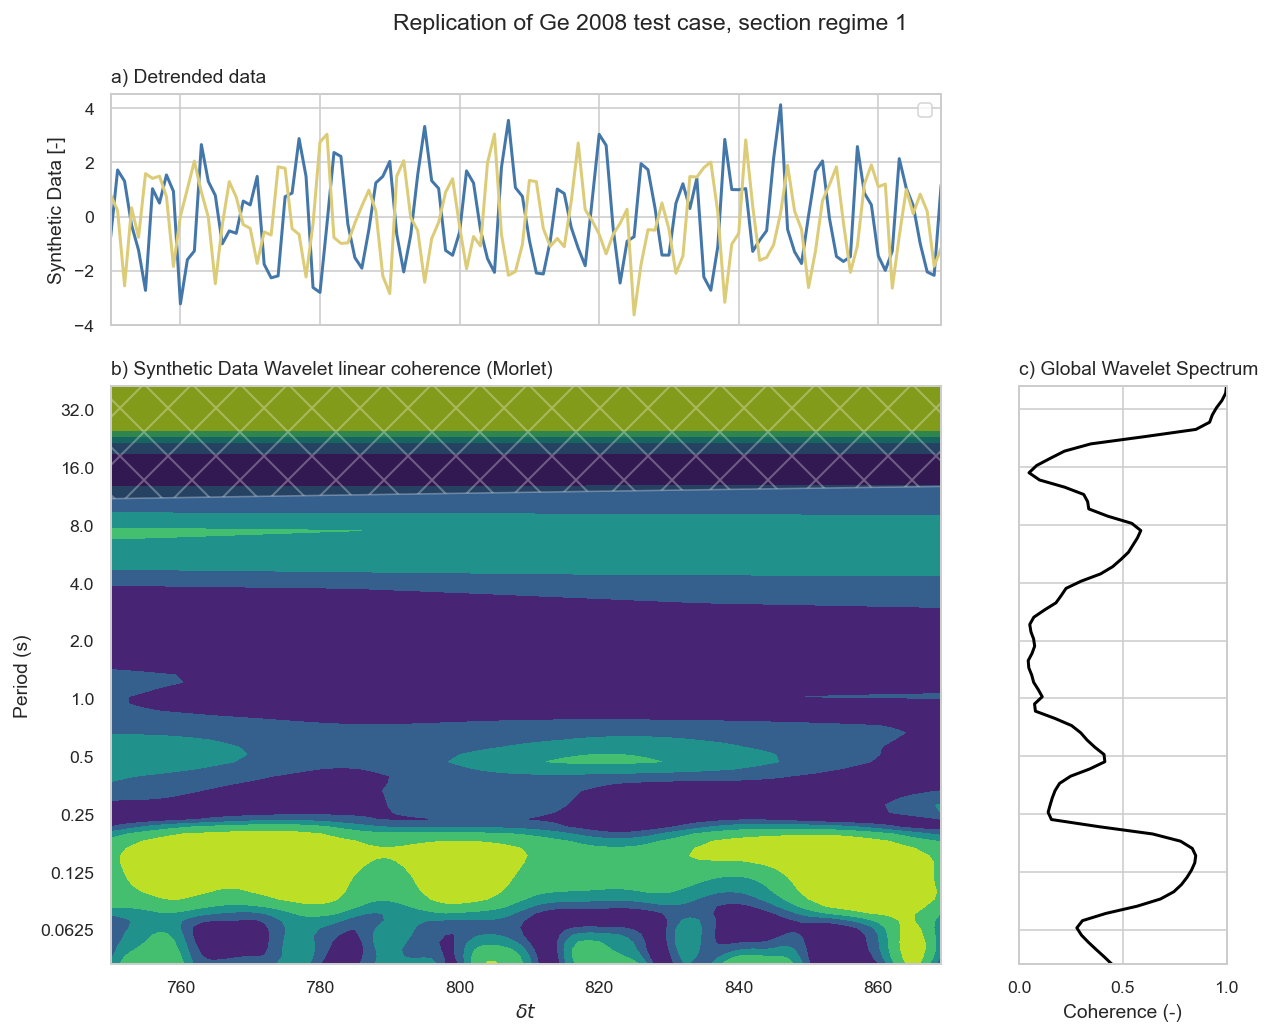

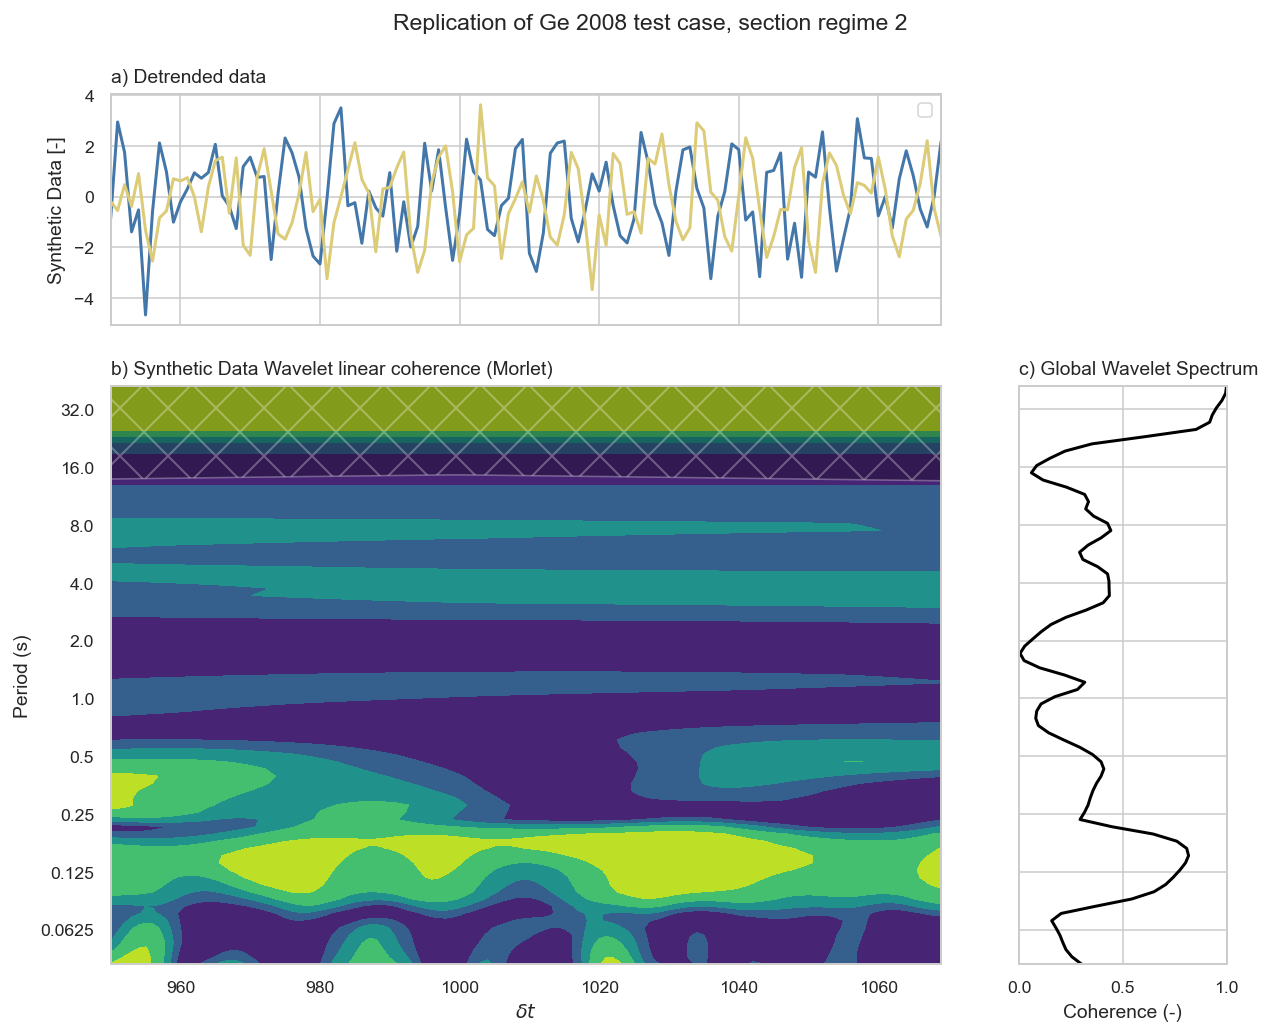

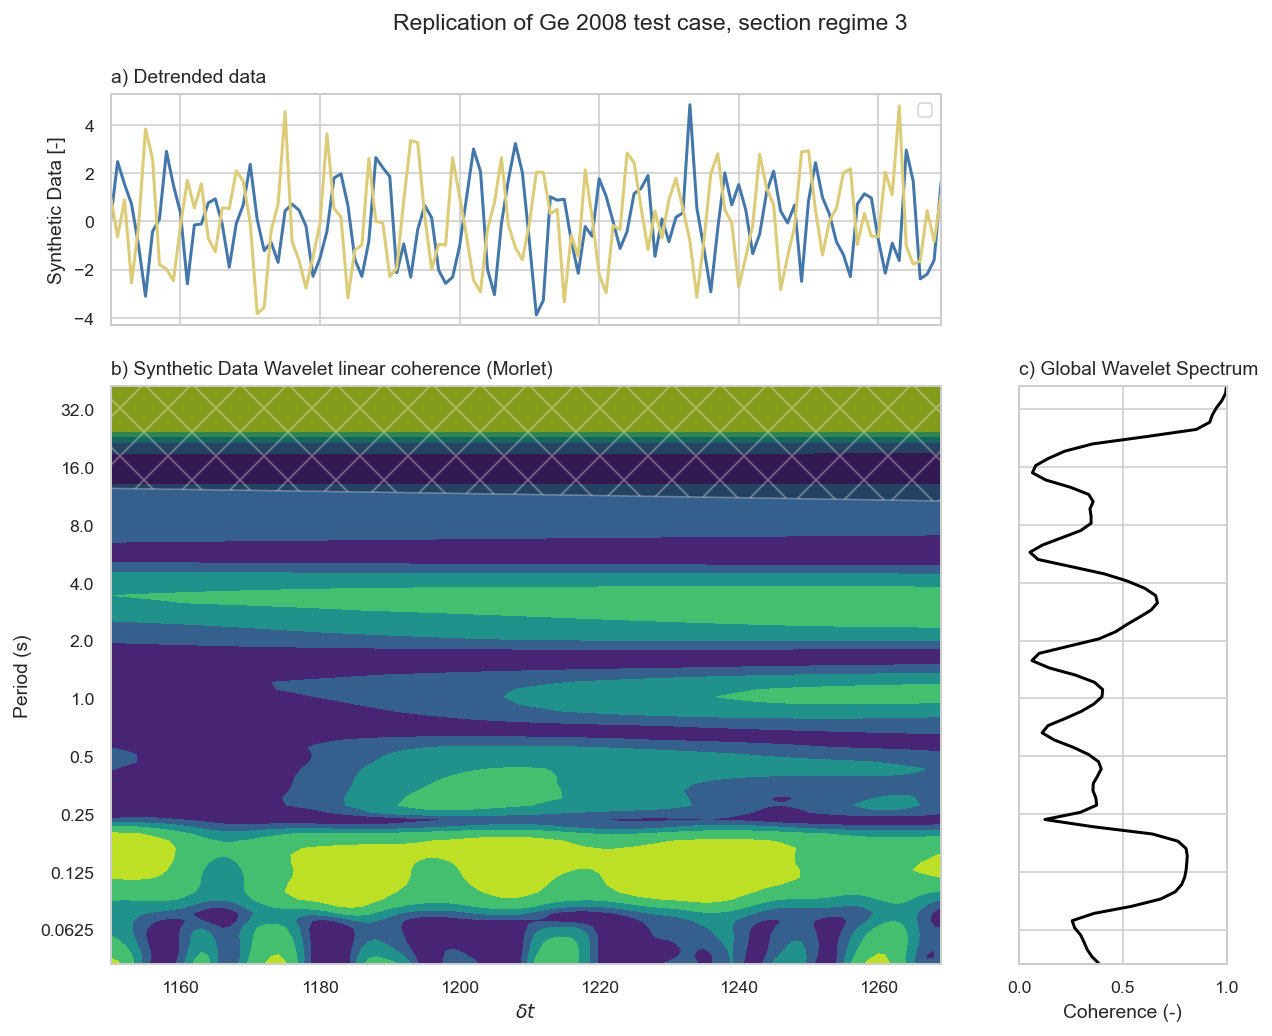

In [10]:
ftitle = 'Replication of Ge 2008 test case, section {}'
fig_labels = {
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 's',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': '$\delta t$'
}

n1 = slice(700 + 50, 700 + 50 + 120)
n2 = slice(700 + 250, 700 + 250 + 120)
n3 = slice(700 + 450, 700 + 450 + 120)

n = n1
fig_labels['title'] = ftitle.format('regime 1')
cwt_plt.plot_wv_power(
    signal_norm=[x[n], y[n]],
    x=t[n],
    dx=sampling_p,
    period=period,
    power=WCT[:, n],
    coi=coi_G08[n],
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True
)

n = n2
fig_labels['title'] = ftitle.format('regime 2')
cwt_plt.plot_wv_power(
    signal_norm=[x[n], y[n]],
    x=t[n],
    dx=sampling_p,
    period=period,
    power=WCT[:, n],
    coi=coi_G08[n],
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True
)

n = n3
fig_labels['title'] = ftitle.format('regime 3')
cwt_plt.plot_wv_power(
    signal_norm=[x[n], y[n]],
    x=t[n],
    dx=sampling_p,
    period=period,
    power=WCT[:, n],
    coi=coi_G08[n],
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True
)

# Apply significance tests

There are lots of wiggles, which wiggles are the important wiggles?

## Visualize the biwavelet coherence significance tests

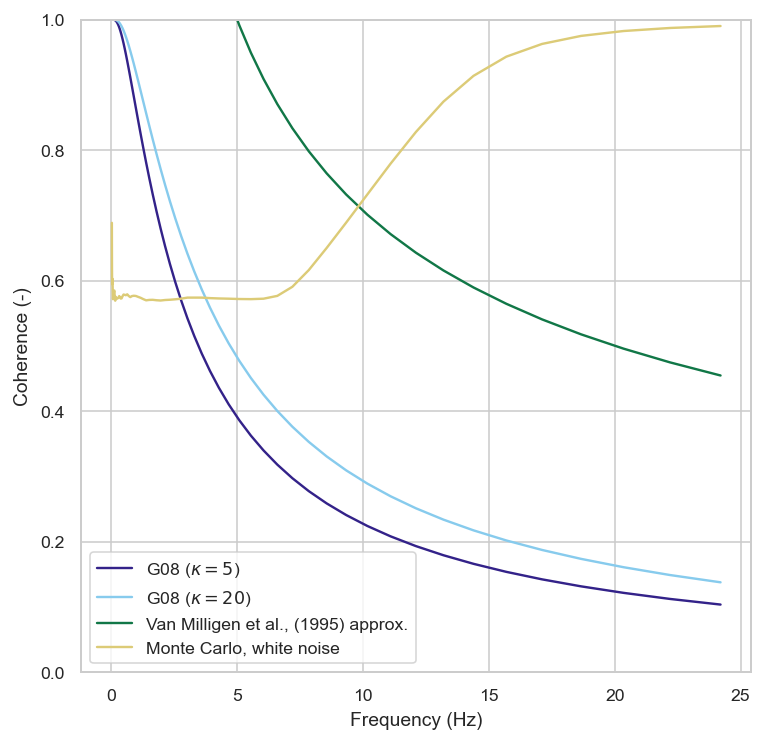

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sig_g08_k5 = wlc_gwn_sig(mother, 40, 1 / period, sampling_f, kappa=5)
sig_g08_k20 = wlc_gwn_sig(mother, 40, 1 / period, sampling_f, kappa=20)
sig_approx = wlc_gwn_approx_sig(40, 1 / period, sampling_f)

# Plot the results to compare to Fig 4 of G08
ax.plot(1/ period, sig_g08_k5, label='G08 ($\kappa=5$)')
ax.plot(1/ period, sig_g08_k20, label='G08 ($\kappa=20$)')
ax.plot(1/ period, sig_approx, label='Van Milligen et al., (1995) approx.')
ax.plot(1/ period, sig_gwn, label='Monte Carlo, white noise')
ax.set_ylim(0, 1)
ax.set_ylabel('Coherence (-)')
ax.set_xlabel('Frequency (Hz)')
ax.legend()

Well that's all over the place.

__G08__: These results are not correct -- they do not match Figure 4 in G08. I cannot ascertain where (or if) an error happened in my implementation. Given that G08 is generally more limited as a stationarity test and that most studies implement a bootstrap or Monte-Carlo approach, I will end my inquiry here. Two side notes, first, an earlier approximation Von Milligen et al. is not useful as it blows up at low frequencies. Second, the G08 test is for scale-averaged coherence. If you extend it to average globally (e.g., N=2000), the significance test drops to effectively zero. This behavior is incorrect.

__Monte Carlo__: This has the opposite trend of the other statistical tests. I actually think it makes more sense. There are many, many more effective samples at higher frequencies. Intuitively, I would believe that means a given coherence needs to exceed a relatively larger level of the significance at these higher frequencies. The Monte-Carlo method captures that. Then, the blip around $f=0$ is a consquence of the COI, where the relatively few/no samples exist, again necesitating a higher significance.

Is that logic right?

### Test against the toy dataset

Text(0.5, 0, 'Frequency (Hz)')

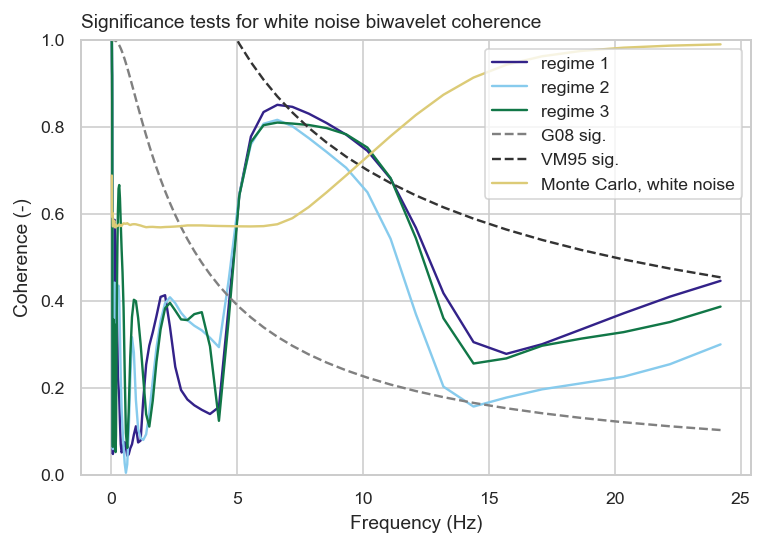

In [12]:
n = n1
plt.plot(1 / period, WCT[:, n].mean(axis=1), label='regime 1')

n = n2
plt.plot(1 / period, WCT[:, n].mean(axis=1), label='regime 2')

n = n3
plt.plot(1 / period, WCT[:, n].mean(axis=1), label='regime 3')

plt.plot(1 / period, sig_g08_k5, ls='--', color='0.5', label='G08 sig.')
plt.plot(1 / period, sig_approx, ls='--', color='0.2', label='VM95 sig.')
plt.plot(1/ period, sig_gwn, label='Monte Carlo, white noise')
plt.gca().set_ylim(0, 1)
plt.gca().legend()
plt.gca().set_title('Significance tests for white noise biwavelet coherence', loc='left')
plt.gca().set_ylabel('Coherence (-)')
plt.gca().set_xlabel('Frequency (Hz)')

The G08 significance testing seems pretty gorperd (higher frequencies require a lower threshold to be significant?). Instead I will examine the Monte-Carlo approach. 

# Examining the Monte-Carlo approach

The pycwt implementation is _PAINFULLY_ slow, taking up to a half hour to produce one estimate of the lag (at least on my potatoe laptop). Since I want to do a number of iterations, plus it generates this weird blip at the longest wavelengths, I will check manually what this test generates for a rednoise null hypothesis.

Tests:

1) Do we quickly converge in a way that the number of iterations is unreasonable? For the wavelet properties I use, the time series has length N=12000, with very little to no effect of the COI at the longest wavelengths. This already is a huge number of realizations of each wavelength for the spectra, so doing an additional e.g., 300, may be overkill. 

2) Verify that red noise function returns a flat spectra given a small AR1 coefficient (should be white noise).

If the MC results make sense, then I will be using those. I will drop the analytic approximations. I suspect people ran into similar problems as I have seen no studies actually plot the G08 values, but instead cite the paper to say that the analytic expressions are difficult.

In [13]:
outside_coi = cwt_stat.coi_where(period, coi, WCT)
masked_WCT = np.ma.array(WCT, mask=~outside_coi)
unmasked_WCT = np.ma.array(WCT, mask=outside_coi)

As an example, 5 Monte-Carlo draws with the wavelet properties specified by the variable `octaves` gives over 60000 samples. Even for the longest wavelengths this is still about 20 samples... Do we really need 300 Monte-Carlo draws?

Also, I cannot figure out _at all_ what the `coherence coefficient counter` is doing. I explore how it compares to a direct Monte-Carlo simulation below.

We could get even more draws for the longest wavelengths by increasing `N`. Or we could acknowledge that the longest wavelengths can not be trusted, especially when our test data is short enough that the longest wavelengths are entirely subsumed within the coi. One way to do that would be to pass the data length as an argument in addition to the wavelet properties. Then we know that e.g. the longest wavelengths were never going to be tested anyway.

# Developing a direct Monte-Carlo biwavelet coherence approach

The next cells are an exploration that formed a basis for the helper functions included with this notebook.

### Compare the Monte-Carlo simulations using the pycwt approach (n=300) to the brute force Monte-Carlo (n=30)

In [14]:
from tqdm import tqdm
from pycwt.helpers import find


mc_count = 60
al1 = 0.001
al2 = 0.001
wavelet=mother
significance_level = 0.95
# Choose N so that largest scale has at least some part outside the COI
J = np.int(octaves[1])
dj = octaves[0]
dt = sampling_p
s0 = dt * 2
ms = s0 * (2 ** (J * dj)) / dt
N = int(np.ceil(ms * 6))
noise1 = pycwt.rednoise(N, al1, 1)
nW1, sj, freq, coi, _, _ = pycwt.cwt(noise1, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

period = np.ones([1, N]) / freq[:, None]
coi = np.ones([J + 1, 1]) * coi[None, :]
outsidecoi = (period <= coi)
scales = np.ones([1, N]) * sj[:, None]
sig95 = np.zeros(J + 1)
maxscale = find(outsidecoi.any(axis=1))[-1]
sig95[outsidecoi.any(axis=1)] = np.nan

nbins = mc_count
wlc = np.ma.zeros([J + 1, nbins])
coh = np.ma.zeros([J + 1, N, nbins])
# Displays progress bar with tqdm
for n_mc in tqdm(range(mc_count)):#, disable=not progress):
    # Generates two red-noise signals with lag-1 autoregressive
    # coefficients given by al1 and al2

    # The rednoise function has an error by calling the wrong random function
    # from numpy. I avoid that here.
    if al1 == 0:
        noise1 =  np.random.normal(0, 1, size=N)
    else:
        noise1 = pycwt.rednoise(N, al1, 1)

    if al2 == 0:
        noise2 =  np.random.normal(0, 1, size=N)
    else:
        noise2 = pycwt.rednoise(N, al2, 1)

    # Calculate the cross wavelet transform of both red-noise signals
    kwargs = dict(dt=dt, dj=dj, s0=s0, J=J, wavelet=wavelet)
    nW1, sj, freq, coi, _, _ = pycwt.cwt(noise1, **kwargs)
    nW2, sj, freq, coi, _, _ = pycwt.cwt(noise2, **kwargs)
    nW12 = nW1 * nW2.conj()
    # Smooth wavelet wavelet transforms and calculate wavelet coherence
    # between both signals.
    S1 = wavelet.smooth(np.abs(nW1) ** 2 / scales, dt, dj, sj)
    S2 = wavelet.smooth(np.abs(nW2) ** 2 / scales, dt, dj, sj)
    S12 = wavelet.smooth(nW12 / scales, dt, dj, sj)
    R2 = np.ma.array(np.abs(S12) ** 2 / (S1 * S2), mask=~outsidecoi)
    coh[:, :, n_mc] = R2

period = period[:, 0]

100%|██████████| 60/60 [00:24<00:00,  2.50it/s]


Make sure the masking works as intended:

Text(0.5, 0, 'Time (s)')

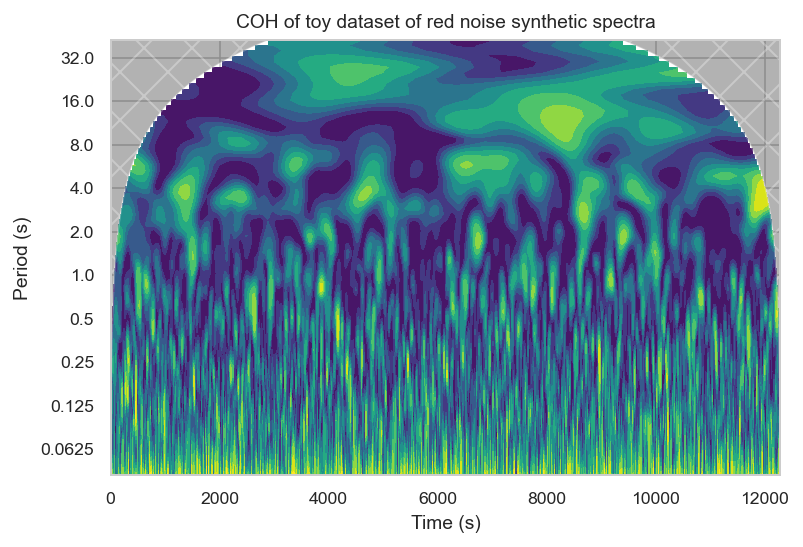

In [15]:
fig, ax = plt.subplots(1, 1,)
cwt_plt.plot_periodogram(
    coh[:, :, n_mc], np.arange(0, N), dt,
    period, coi=coi, ax=ax, sig95=None,
    levels=np.arange(0, 1, 0.1), log_power=False,
)
ax.set_title('COH of toy dataset of red noise synthetic spectra')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

The masking works -- no coherence inside COI.

# Apply Monte-Carlo significance testing

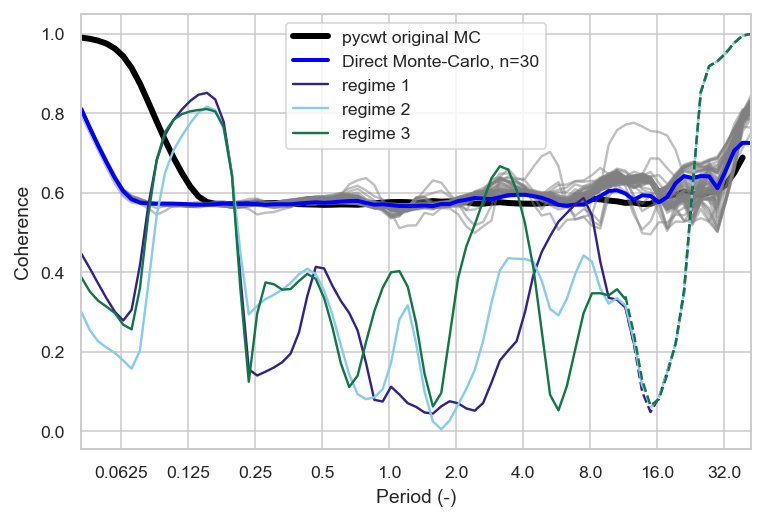

In [16]:
Xticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# period = period[:, 0]
ax.plot(np.log2(period), sig_gwn, color='k', lw=3, label='pycwt original MC')
for n in np.arange(mc_count):
    coh_reshape = np.reshape(coh[:, :, :n+1], (81, N * (n + 1)))
    ax.plot(
        np.log2(period),
        np.percentile(coh_reshape, 95, axis=1),
        color='0.5',
        alpha=0.5,
    )

n = mc_count - 1
coh_reshape = np.reshape(coh[:, :, :n+1], (81, N * (n + 1)))
ax.plot(
    np.log2(period),
    np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
    color='b',
    lw=2,
    label='Direct Monte-Carlo, n=30'
)

n = n1
ax.plot(np.log2(period), masked_WCT[:, n].mean(axis=1), label='regime 1', color=flatui[0])
ax.plot(np.log2(period), unmasked_WCT[:, n].mean(axis=1), ls='--', color=flatui[0])
n = n2
ax.plot(np.log2(period), masked_WCT[:, n].mean(axis=1), label='regime 2', color=flatui[1])
ax.plot(np.log2(period), unmasked_WCT[:, n].mean(axis=1), ls='--', color=flatui[1])
n = n3
ax.plot(np.log2(period), masked_WCT[:, n].mean(axis=1), label='regime 3', color=flatui[2])
ax.plot(np.log2(period), unmasked_WCT[:, n].mean(axis=1), ls='--', color=flatui[2])

ax.set_xticks(np.log2(Xticks))
ax.set_xticklabels(Xticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([period.min(), period.max()]))
ax.set_ylabel('Coherence')
ax.set_xlabel('Period (-)')
ax.legend()

The dashed lines for the regimes indicate wavelengths that are entirely within the COI and therefore should not be interpreted.

### Comparison between direct and pycwt:

The approximate Monte-Carlo results from pycwt generate weird edge effects relative to the direct Monte-Carlo approach. The direct method so quickly converges at the higher frequencies that the difference is not a number of samples. I will open an issue on the pycwt page regarding this behavior as I believe it is in error. I see two errors:

1) Using synthetic time series longer than the original time series (and therefore different wavelet properties). The intent was to extend the MC into the COI rather than masking for the COI. However, this leads to the implication that we can test frequencies entirely contained within the COI and that the significance threshold does not increase for frequencies near the COI due to a reduced number of samples, both of which are false.

2) The edge effects at high frequencies/small periods do not match the direct MC approach.

### Solving Error #1: Imposing an equal number of samples in the MC

Setting the length of the Monte-Carlo simulation to be different than the length of the tested data means that we are asserting different numbers of samples at a given wavelet frequency. So let's re-do this code with the assertion that N = len(signal). This is in line with the logic behind traditional significance tests in which we keep track of the degrees of freedom for a given spectra realization.

In [17]:
mc_count = 60
al1 = 0.001
al2 = 0.001
wavelet = mother
significance_level = 0.95
J = np.int(octaves[1])
dj = octaves[0]
dt = sampling_p
s0 = dt * 2
slen = np.int(datalen)
# Choose N so that largest scale has at least some part outside the COI
ms = s0 * (2 ** (J * dj)) / dt
N = slen
noise1 = pycwt.rednoise(N, al1, 1)
nW1, sj, freq, coi, _, _ = pycwt.cwt(noise1, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

period = np.ones([1, N]) / freq[:, None]
coi = np.ones([J + 1, 1]) * coi[None, :]
outsidecoi = (period <= coi)
scales = np.ones([1, N]) * sj[:, None]
sig95 = np.zeros(J + 1)
maxscale = find(outsidecoi.any(axis=1))[-1]
sig95[outsidecoi.any(axis=1)] = np.nan

nbins = mc_count
wlc = np.ma.zeros([J + 1, nbins])
coh_reduced_n = np.ma.zeros([J + 1, N, nbins])
# Displays progress bar with tqdm
for n_mc in tqdm(range(mc_count)):#, disable=not progress):
    # Generates two red-noise signals with lag-1 autoregressive
    # coefficients given by al1 and al2

    # The rednoise function has an error by calling the wrong random function
    # from numpy. I avoid that here.
    if al1 == 0:
        noise1 =  np.random.normal(0, 1, size=N)
    else:
        noise1 = pycwt.rednoise(N, al1, 1)

    if al2 == 0:
        noise2 =  np.random.normal(0, 1, size=N)
    else:
        noise2 = pycwt.rednoise(N, al2, 1)

    # Calculate the cross wavelet transform of both red-noise signals
    kwargs = dict(dt=dt, dj=dj, s0=s0, J=J, wavelet=wavelet)
    nW1, sj, freq, coi, _, _ = pycwt.cwt(noise1, **kwargs)
    nW2, sj, freq, coi, _, _ = pycwt.cwt(noise2, **kwargs)
    nW12 = nW1 * nW2.conj()
    # Smooth wavelet wavelet transforms and calculate wavelet coherence
    # between both signals.
    S1 = wavelet.smooth(np.abs(nW1) ** 2 / scales, dt, dj, sj)
    S2 = wavelet.smooth(np.abs(nW2) ** 2 / scales, dt, dj, sj)
    S12 = wavelet.smooth(nW12 / scales, dt, dj, sj)
    R2 = np.ma.array(np.abs(S12) ** 2 / (S1 * S2), mask=~outsidecoi)
    coh_reduced_n[:, :, n_mc] = R2

period = period[:, 0]

100%|██████████| 60/60 [00:03<00:00, 17.33it/s]


### Examine the convergence of the Monte-Carlo simulations with equal number of samples

In [18]:
import warnings
warnings.filterwarnings("ignore")

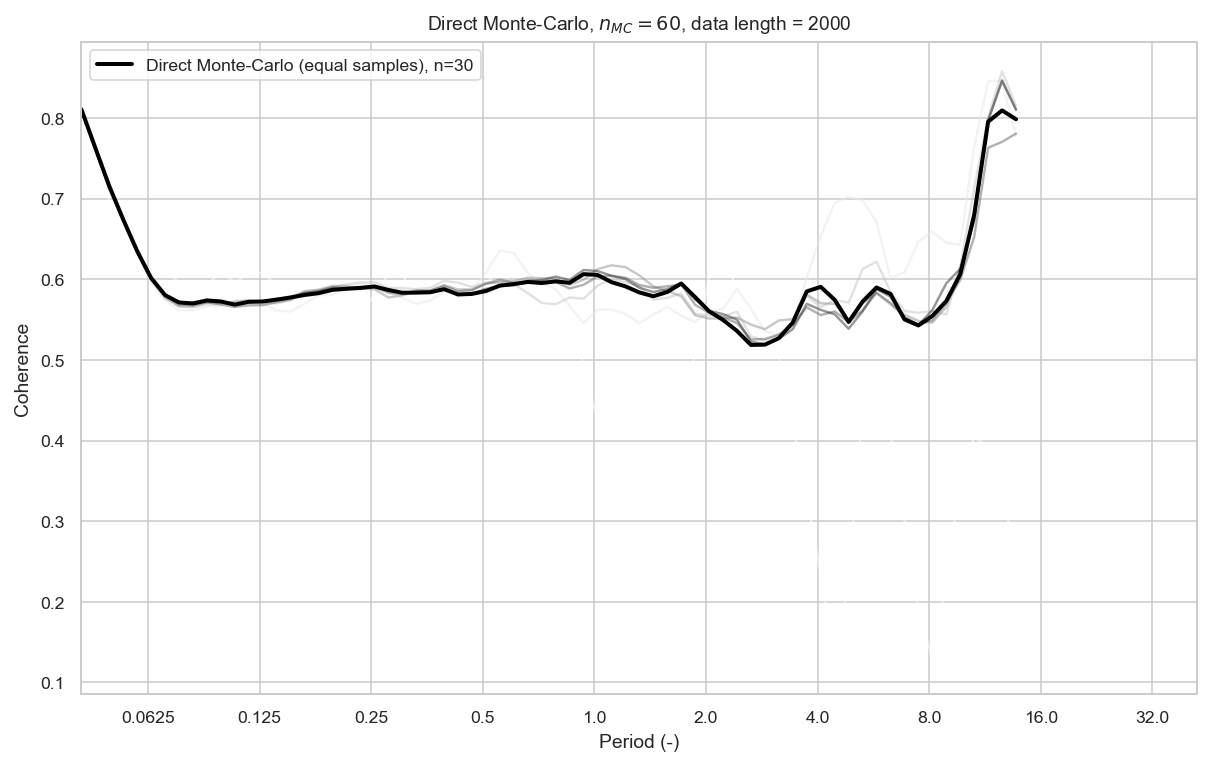

In [19]:
Xticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colorseq = plt.cm.Greys(np.linspace(0, 1, mc_count))
for n in np.arange(0, mc_count, 10):
    coh_reshape = np.reshape(coh_reduced_n[:, :, :n + 1], (81, slen * (n + 1)))
    ax.plot(
        np.log2(period),
        np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
        color=colorseq[n],
        alpha=0.5,
    )

n = mc_count
# Direct MC: Reduced samples
coh_reshape = np.reshape(coh_reduced_n[:, :, :n+1], (81, slen * n))
ax.plot(
    np.log2(period),
    np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
    color='k',
    lw=2,
    label='Direct Monte-Carlo (equal samples), n=30'
)

ax.set_xticks(np.log2(Xticks))
ax.set_xticklabels(Xticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([period.min(), period.max()]))
ax.set_ylabel('Coherence')
ax.set_xlabel('Period (-)')
ax.set_title('Direct Monte-Carlo, $n_{MC} = 60$, data length = 2000')
ax.legend()

The white to dark grey lines indicate increasing number of Monte-Carlo simulations used to derive the significance level. Clearly converges at the higher frequencies, may not have convered at the longer frequencies.

### Compare to the toy dataset

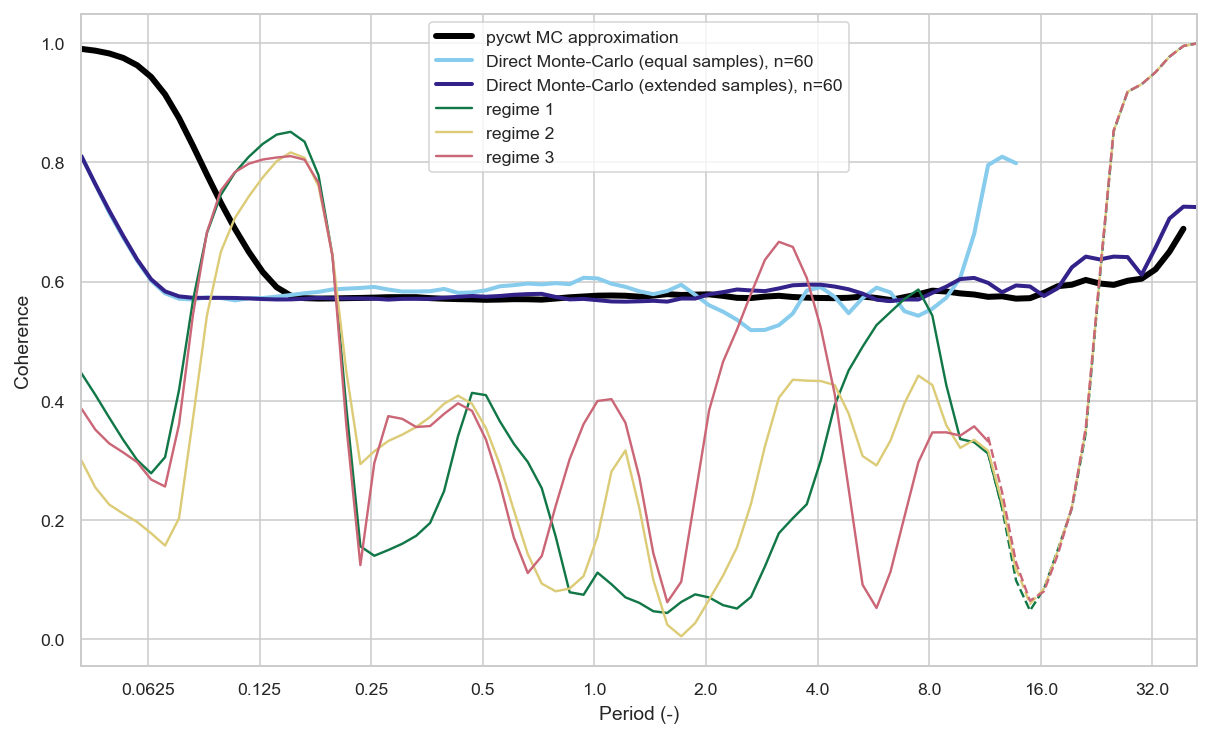

In [20]:
Xticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(np.log2(period), sig_gwn, color='k', lw=3, label='pycwt MC approximation')

n = mc_count
# Direct MC: Reduced samples
coh_reshape = np.reshape(coh_reduced_n[:, :, :n+1], (81, slen * n))
ax.plot(
    np.log2(period),
    np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
    color=flatui[1],
    lw=2,
    label='Direct Monte-Carlo (equal samples), n={}'.format(mc_count)
)

# Direct MC: extended samples
coh_reshape = np.reshape(coh[:, :, :n+1], (81, 12288 * n))
ax.plot(
    np.log2(period),
    np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
    color=flatui[0],
    lw=2,
    label='Direct Monte-Carlo (extended samples), n={}'.format(mc_count)
)

n = n1
ax.plot(np.log2(period), masked_WCT[:, n].mean(axis=1), label='regime 1', color=flatui[2])
ax.plot(np.log2(period), unmasked_WCT[:, n].mean(axis=1), ls='--', color=flatui[2])
n = n2
ax.plot(np.log2(period), masked_WCT[:, n].mean(axis=1), label='regime 2', color=flatui[3])
ax.plot(np.log2(period), unmasked_WCT[:, n].mean(axis=1), ls='--', color=flatui[3])
n = n3
ax.plot(np.log2(period), masked_WCT[:, n].mean(axis=1), label='regime 3', color=flatui[4])
ax.plot(np.log2(period), unmasked_WCT[:, n].mean(axis=1), ls='--', color=flatui[4])

ax.set_xticks(np.log2(Xticks))
ax.set_xticklabels(Xticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([period.min(), period.max()]))
ax.set_ylabel('Coherence')
ax.set_xlabel('Period (-)')
ax.legend()

The wiggles of the MC with equal number of samples Number of Monte-Carlo samples towards larger wavelengths may be an issue of the number of samples not converging. We can quickly take a look at that and try to get some intuition for how many samples may be necessary.

The direct MC with the length of the synthetic time series = length of the original data also captures the desired increase in significance threshold as we approach the COI and reduce the number of independent samples as a result.

### Number of samples per frequency bin

A useful improvement for the direct Monte-Carlo significance test may be requiring a certain number of Monte-Carlo realizations for each resolvable frequency. We can test that here. 

Text(0.5, 0, 'Period (s)')

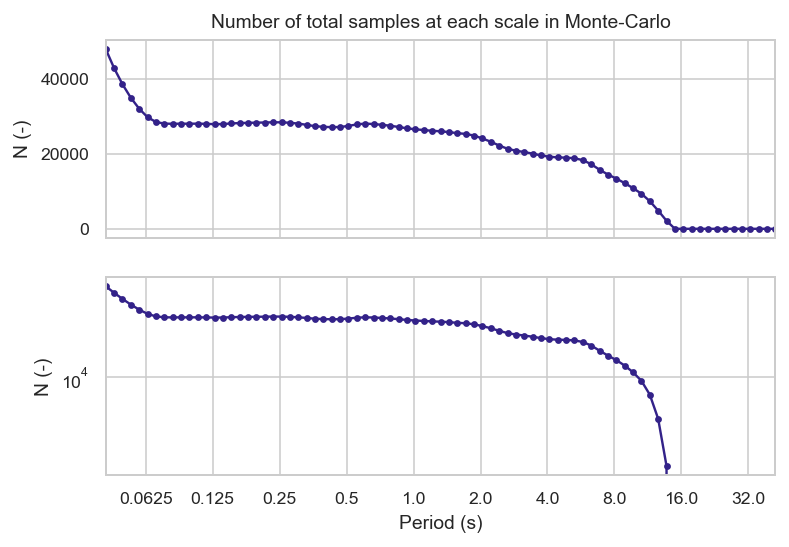

In [21]:
n = mc_count
# Direct MC: Reduced samples
coh_reshape = np.reshape(coh_reduced_n[:, :, :n+1], (81, slen * n))

fig, axes = plt.subplots(2, 1, sharex=True)

# Normalize by the scale number. I am not sure this is a good representation
# of the number of independent samples in a given scale, but I'll try it for now.
ax = axes[0]
ax.plot(np.log2(period), np.nansum(coh_reshape.filled(np.nan), axis=1), marker='.')
ax.set_ylabel('N (-)')
ax.set_title('Number of total samples at each scale in Monte-Carlo')

ax = axes[1]
ax.semilogy(np.log2(period), np.nansum(coh_reshape.filled(np.nan), axis=1), marker='.')
ax.set_ylabel('N (-)')

ax.set_xticks(np.log2(Xticks))
ax.set_xticklabels(Xticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([period.min(), period.max()]))
ax.set_xlabel('Period (s)')


Now the same thing, but dividing by the scale. This is an estimate (not exact, just a ball park) of the number of independent samples for each wavelet scale.

### Now the number of ~independent samples per frequency bin

Text(0.5, 0, 'Period (s)')

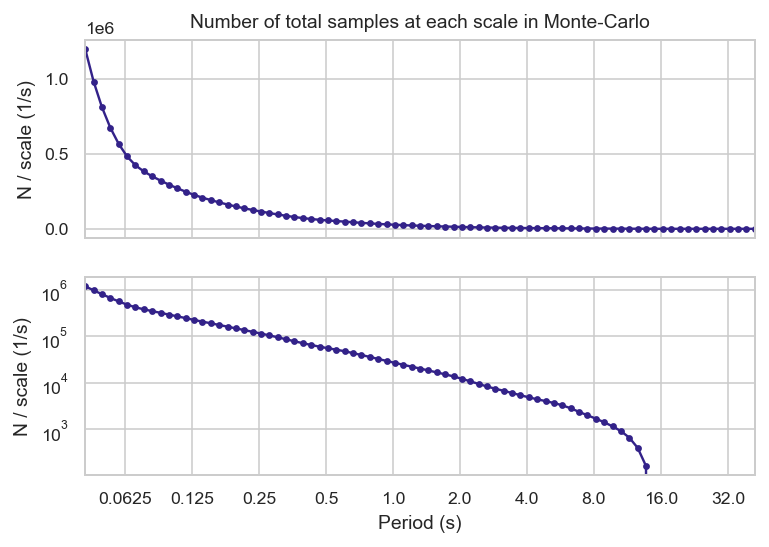

In [22]:
n = mc_count
# Direct MC: Reduced samples
coh_reshape = np.reshape(coh_reduced_n[:, :, :n+1], (81, slen * n))

fig, axes = plt.subplots(2, 1, sharex=True)

# Normalize by the scale number. I am not sure this is a good representation
# of the number of independent samples in a given scale, but I'll try it for now.
ax = axes[0]
ax.plot(np.log2(period), np.nansum(coh_reshape.filled(np.nan), axis=1) / sj, marker='.')
ax.set_ylabel('N / scale (1/s)')
ax.set_title('Number of total samples at each scale in Monte-Carlo')

ax = axes[1]
ax.semilogy(np.log2(period), np.nansum(coh_reshape.filled(np.nan), axis=1) / sj, marker='.')
ax.set_ylabel('N / scale (1/s)')

ax.set_xticks(np.log2(Xticks))
ax.set_xticklabels(Xticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([period.min(), period.max()]))
ax.set_xlabel('Period (s)')


If I want to impose a limit on the largest believable scale in the Monte Carlo testing, then I would say as a hard limit anything less than 1000 samples is probably not believable. The hard drop of the number of independent samples past a period of 8s may be a reasonable way to test for convergence or to exclude points from the test.

The other approach would be to continue doing the Monte-Carlo until we have convergence at the largest resolvable scale. Although I do not believe that the e.g. 15s period will reasonably converge since so much of this particular scale resides in the COI.

## Build into a useable function

After all of that, I think I have a clear picture as to what the significance testing function must look like.

Elements:

__Definitely__ 

- Ability to impose an arbitrary noise function. So here we may want the ability to pass a function into the inner function.
- Return multiple levels of significance or return the coherence simulation directly?

__Good future innovation__

- options for imposing a converge critera
- Some indication of the convergence

# Build arbirtrary noise functions for driving the Monte-Carlo simulations

### First, examine the pycwt red noise function

I believe we may need to implement an alternative to this function as it does not have the correct properties. This motivates developing a Monte-Carlo function that can include an arbitrary noise function.

I test three different levels of red noise. These should have increasingly strong spectral slopes as the noise becomes less white (from n1 which is nearly white to n3 which is strongly red).

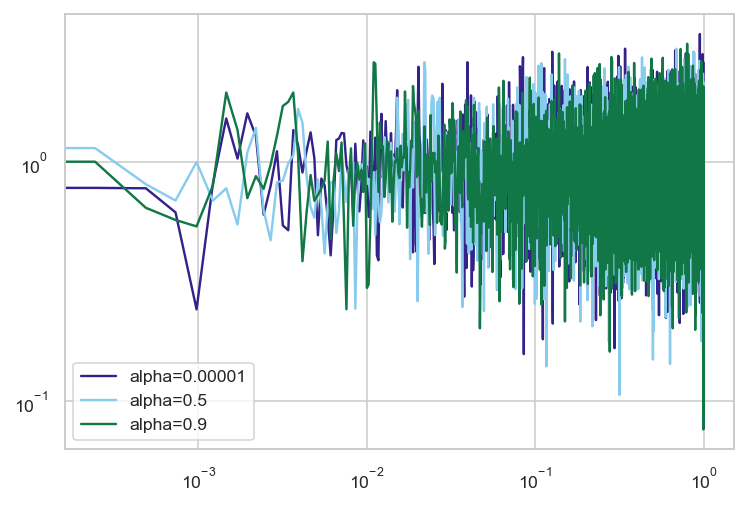

In [23]:
synth_func = pycwt.rednoise
synth_func_kwargs1 = {}
synth_func_args1 = [0.00001, 1]
N = 50000
noise1 = synth_func(N, *synth_func_args1, **synth_func_kwargs1)
synth_func_args1 = [0.5, 1]
noise2 = synth_func(N, *synth_func_args1, **synth_func_kwargs1)
synth_func_args1 = [0.9, 1]
noise3 = synth_func(N, *synth_func_args1, **synth_func_kwargs1)

from matplotlib import mlab
s, f = mlab.psd(noise1, NFFT=2**13)
plt.loglog(f, s, label='alpha=0.00001')

s, f = mlab.psd(noise2, NFFT=2**13)
plt.loglog(f, s, label='alpha=0.5')

s, f = mlab.psd(noise3, NFFT=2**13)
plt.loglog(f, s, label='alpha=0.9')
plt.gca().legend()

Well now I am about 90% convinced that this is not red noise. If it were red noise then the power spectrum would be sloped, not flat. Let's check the wavelet spectrum.

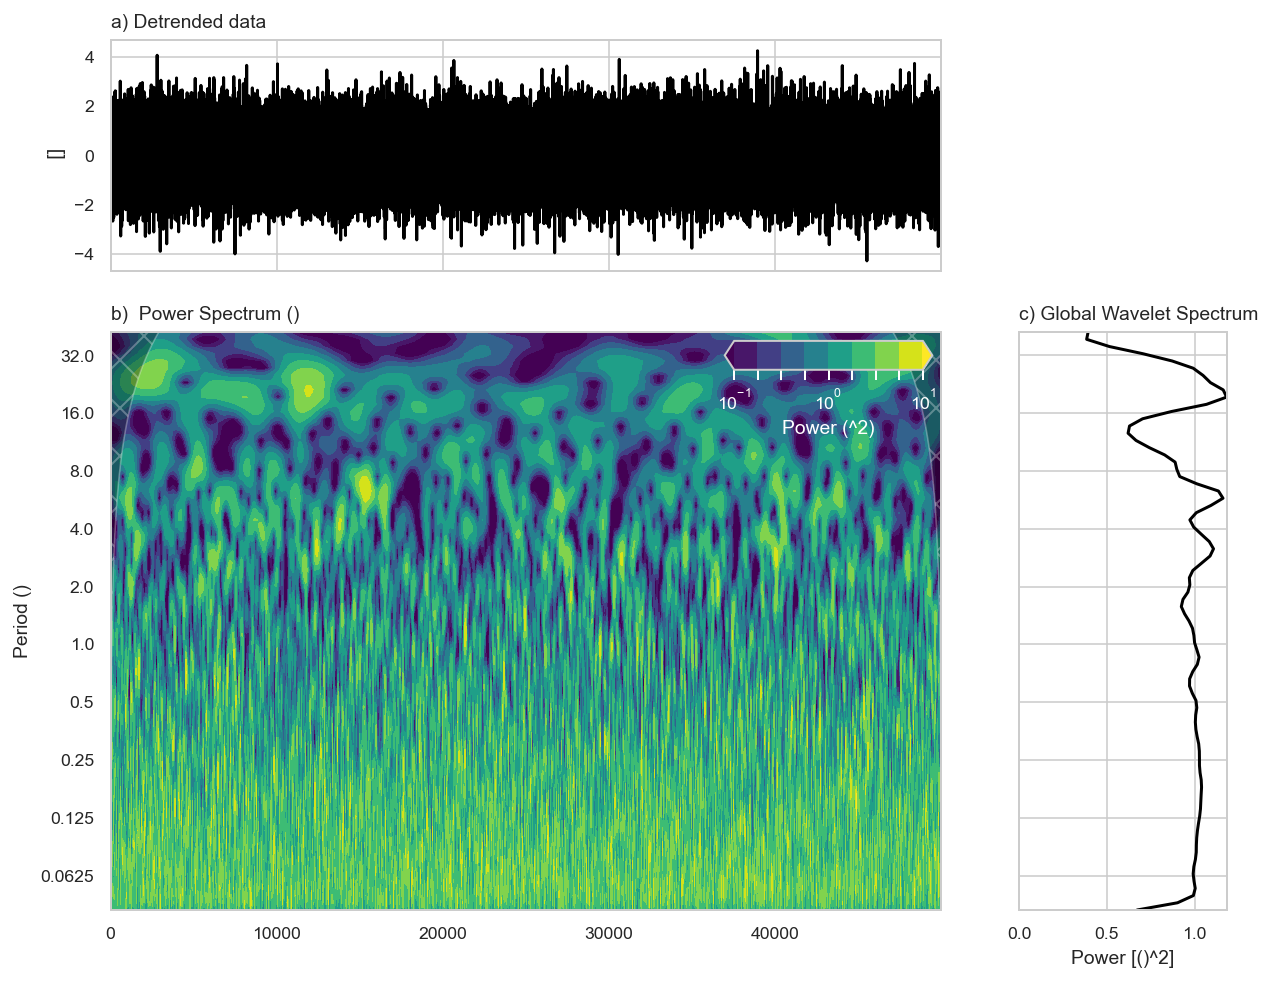

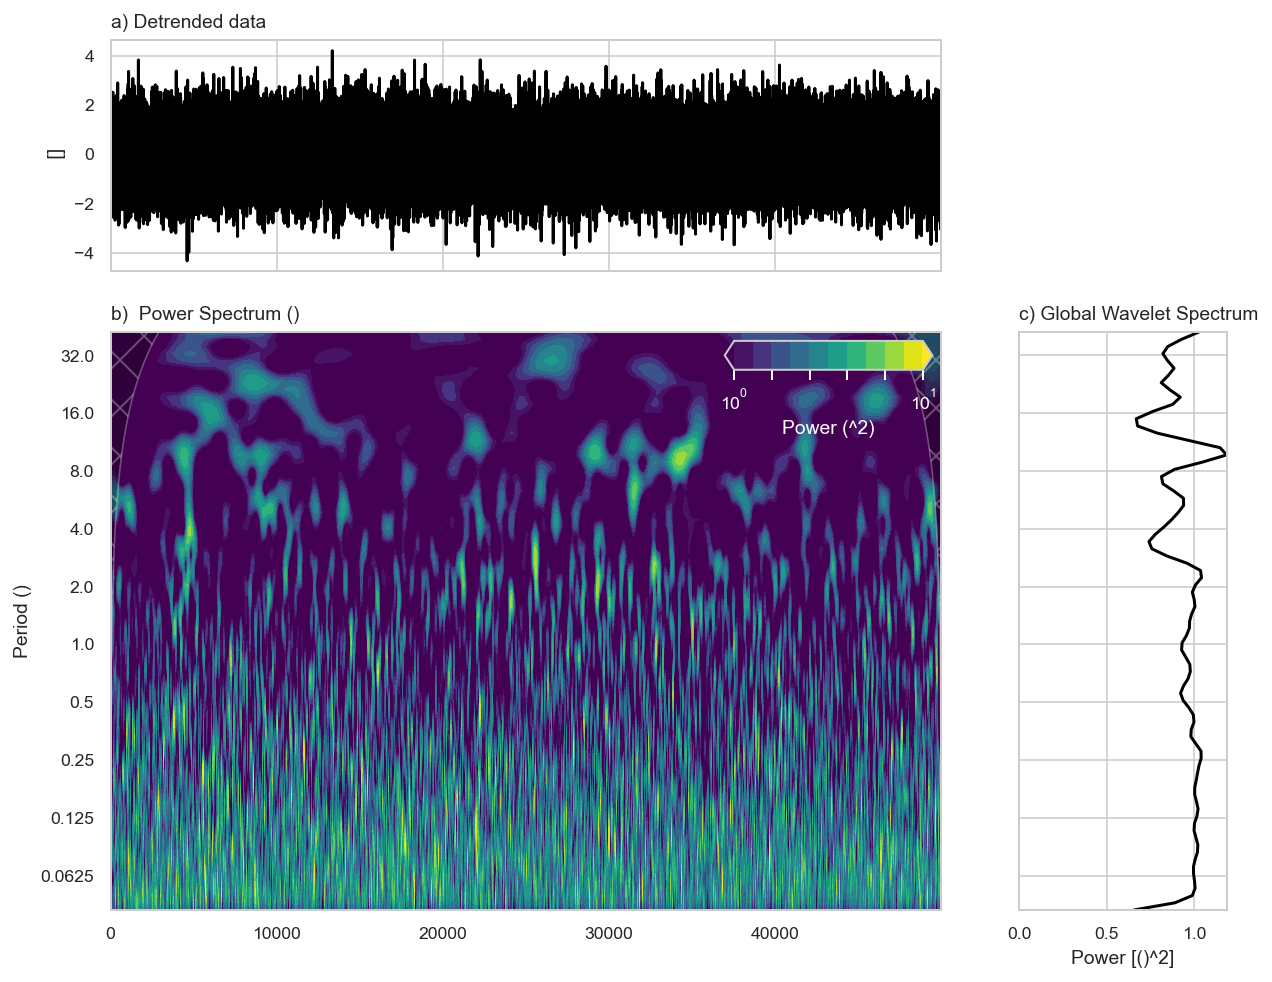

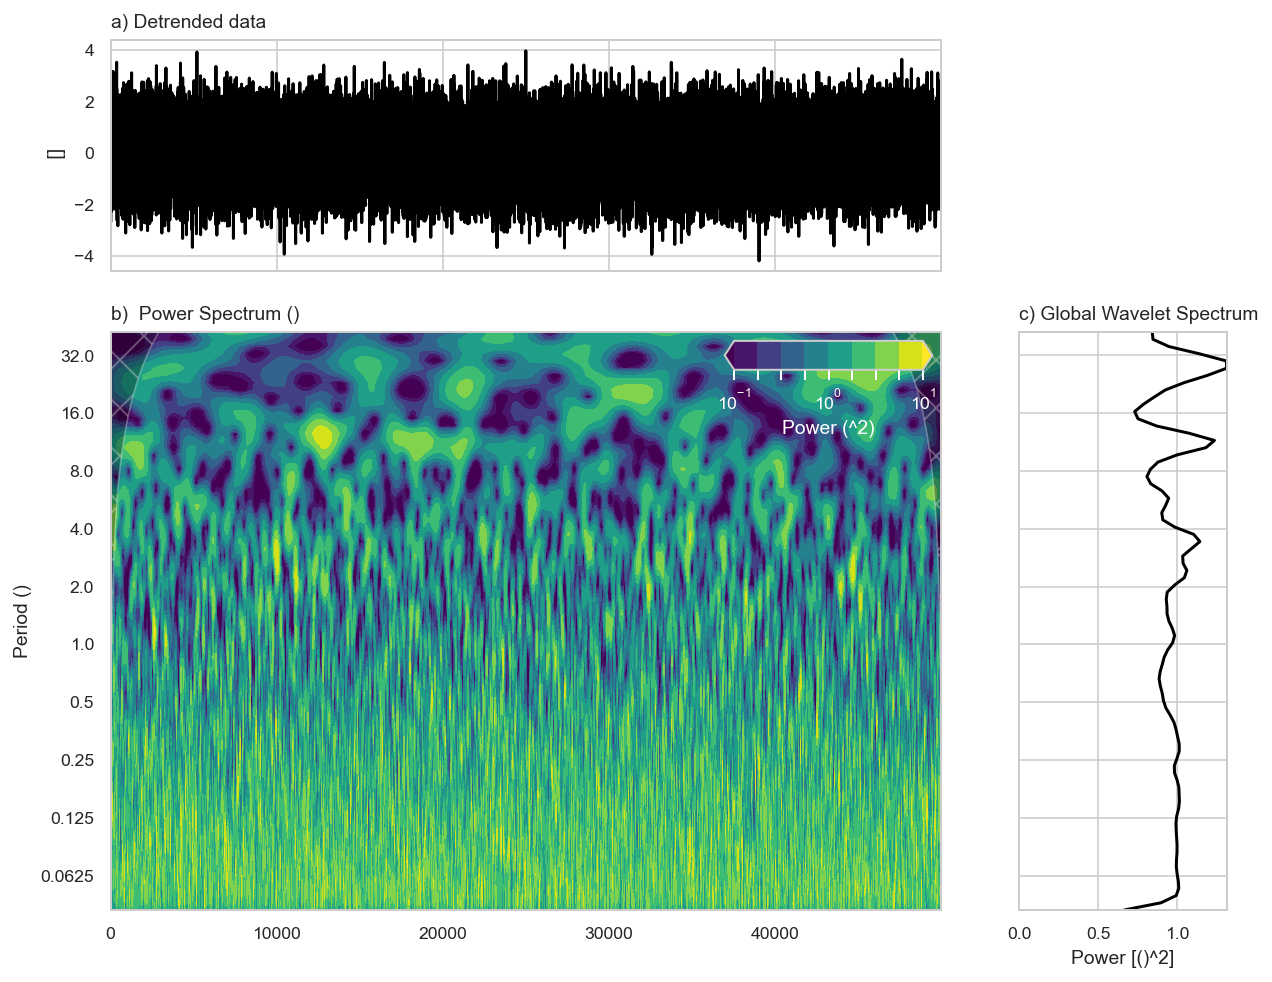

In [24]:
nW1, sj, freq, coi, _, _ = pycwt.cwt(noise1, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

nW2, sj, freq, coi, _, _ = pycwt.cwt(noise2, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

nW3, sj, freq, coi, _, _ = pycwt.cwt(noise3, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

cwt_plt.plot_wv_power(
    signal_norm=noise1,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW1) ** 2,
    coi=coi,
)

cwt_plt.plot_wv_power(
    signal_norm=noise2,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW2) ** 2,
    coi=coi,
)

cwt_plt.plot_wv_power(
    signal_norm=noise3,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW3) ** 2,
    coi=coi,
)

If this is rednoise (and I sincerely doubt it is) then the wavelet spectra should not be flat, especially with such a long synthetic dataset.

#### Interpretation

These spectra are flat, which is wrong.

### Examine the rednoise function in detail

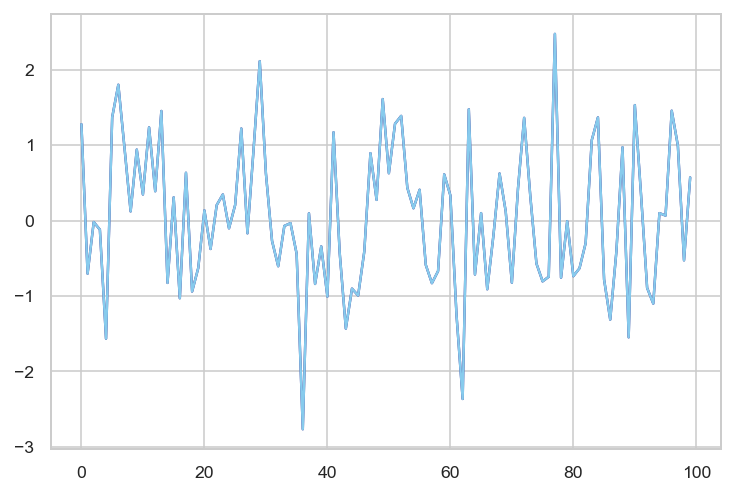

In [25]:
from scipy.signal import lfilter

# This should be strongly non-white when g is close to 1
g = 0.9
# standard deviation of the gaussian white noise
a = 1
# Just a short sample to test
N = 100
tau = int(np.ceil(-2 / np.log(np.abs(g))))

# Save the noise for comparison
noise = np.random.randn(N + tau, 1) * a
# Apply the filter
yr = lfilter([1, 0], [1, -g], noise)
yr = yr[tau:]

# Compare the two
plt.plot(yr)
plt.plot(noise[tau:])

Well here we find the problem. The red noise generator just returns the white noise. Now there are two options:

1) Use a theoretically justified colored noise generator (there is a nice python package that does this)

or

2) Just brute force the lag-1 Markov chain process to generate red noise.

### Implement the colored noise generator

This method is strongly based in a theoretical justification. It appears to model an "infinitely long" Markov chain, as evidenced by the lack of a plateau for the longest wavelengths.

This method produces any colored noise, and not just red (aka Brownian) noise.

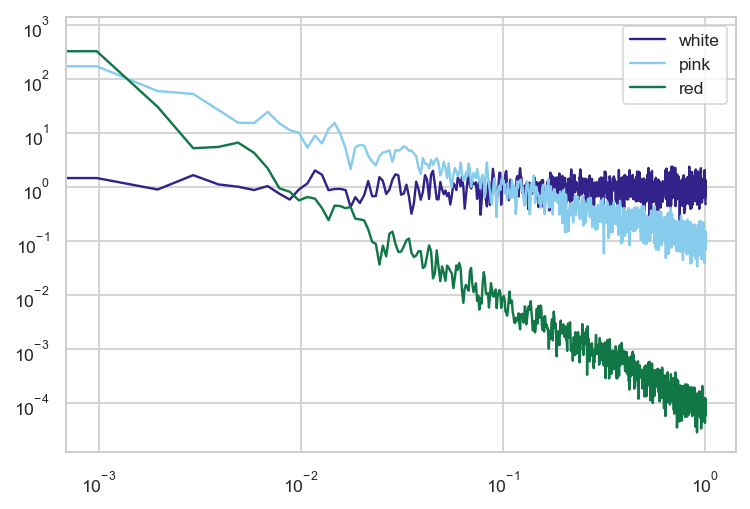

In [26]:
import colorednoise as cn
beta = 1 # the exponent
N = 15000 # number of samples to generate
y_white = cn.powerlaw_psd_gaussian(0, N)
y_pink = cn.powerlaw_psd_gaussian(1, N)
y_red = cn.powerlaw_psd_gaussian(2, N)

# optionally plot the Power Spectral Density with Matplotlib
from matplotlib import mlab
s, f = mlab.psd(y_white, NFFT=2**11)
plt.loglog(f, s, label='white')

s, f = mlab.psd(y_pink, NFFT=2**11)
plt.loglog(f, s, label='pink')

s, f = mlab.psd(y_red, NFFT=2**11)
plt.loglog(f, s, label='red')
plt.gca().legend()

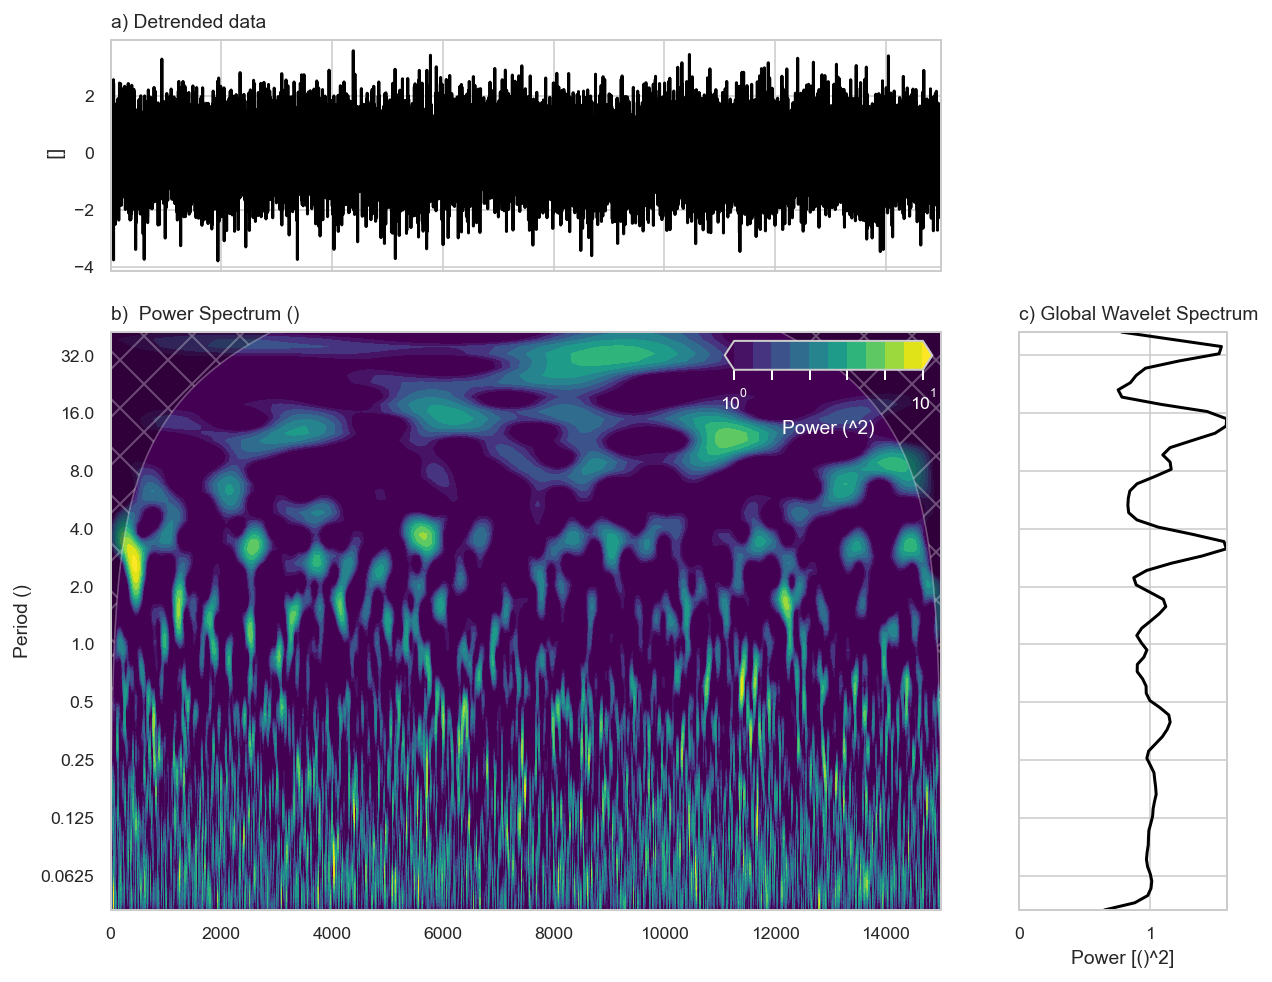

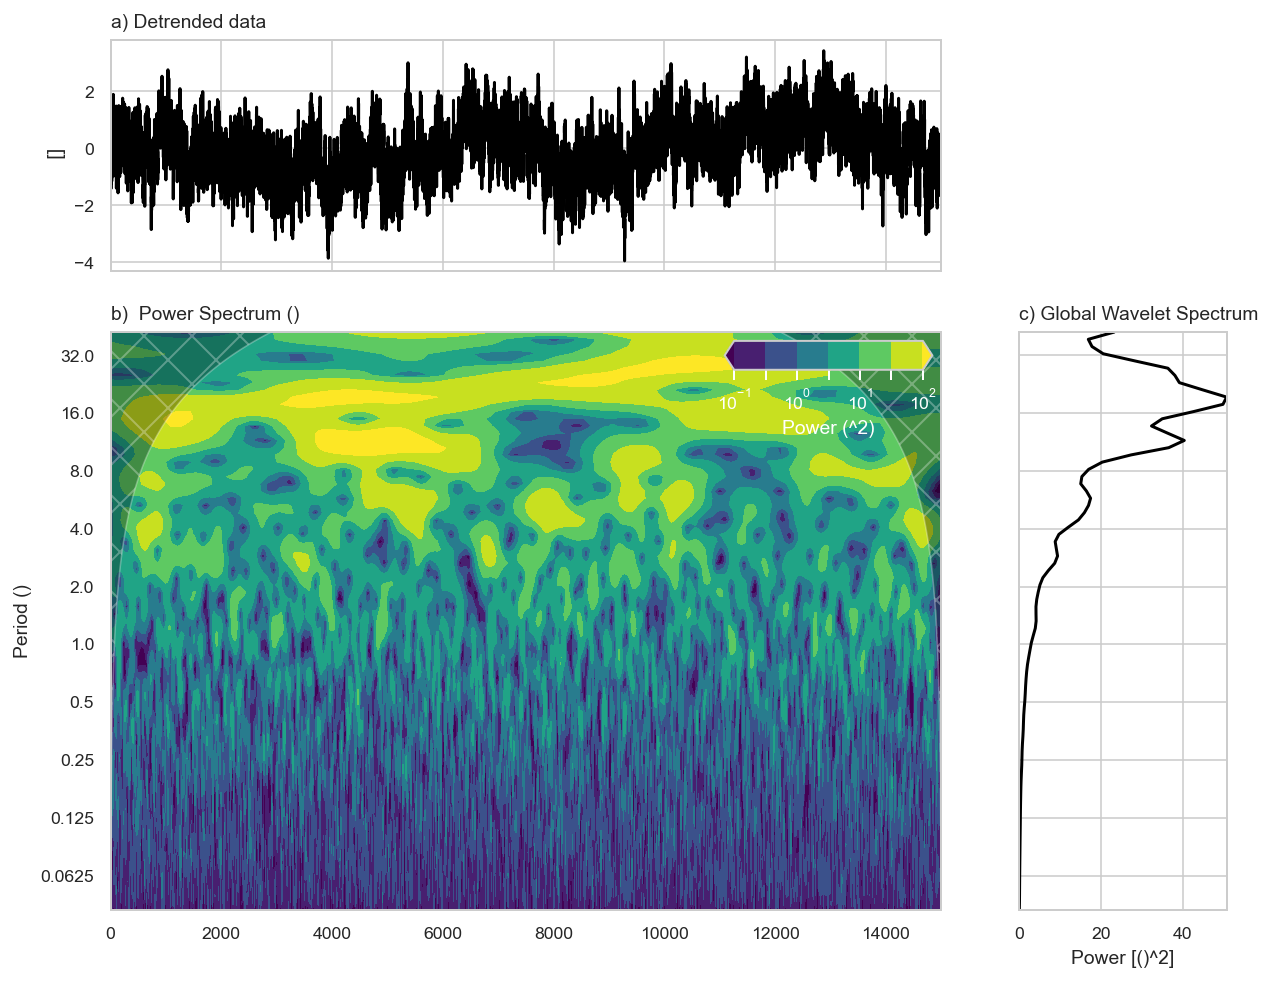

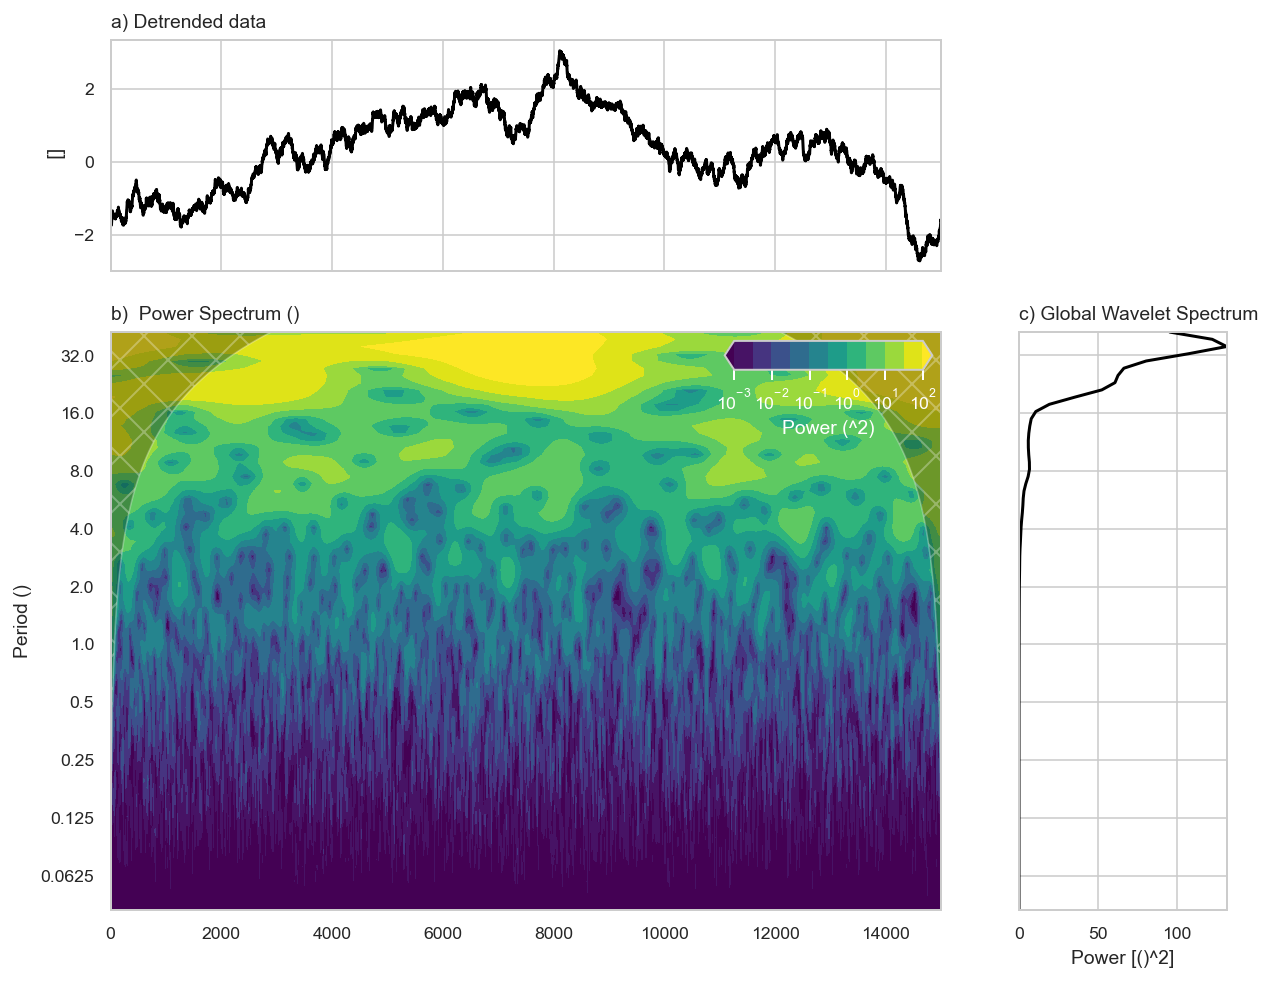

In [27]:
nW1, sj, freq, coi, _, _ = pycwt.cwt(y_white, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

nW2, sj, freq, coi, _, _ = pycwt.cwt(y_pink, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

nW3, sj, freq, coi, _, _ = pycwt.cwt(y_red, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

cwt_plt.plot_wv_power(
    signal_norm=y_white,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW1) ** 2,
    coi=coi,
)

cwt_plt.plot_wv_power(
    signal_norm=y_pink,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW2) ** 2,
    coi=coi,
)

cwt_plt.plot_wv_power(
    signal_norm=y_red,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW3) ** 2,
    coi=coi,
)

Alright, that behaves as expected. So my intuition above was correct. The rednoise generator does not generate red noise. However, there is now an unknown method for relating the term $\beta$ from the theoretical power spectrum distribution of colored noise to the e.g. lag-1 coefficient for a Markov process. I poured some time into this, but could not come up with a convincing answer, so I just opted to brute force the Markov chain simulation.

### Build my own Markov chain lag-1 generator

I won't get fancy here. I will just brute force the data. In order to reduce the effect of initial conditions, we must simulate a long red noise time series and only sample the last portion of it. The resulting data must first be generated to remove the edge effects of initilization.

In [28]:
def ar1_generator(N, alpha, noise):
    '''
    Generates a Markov chain lag-1 process.
    '''
    
    y = np.zeros((3 * N,))
    # Simulate a longer period and just return the last N point
    # to remove edge effects.
    for t in range(1, 3 * N):
        y[t] = alpha * y[t - 1] + np.random.normal(scale=noise)
        
    return y[-N:]

In [29]:
N = 2000
y_sml_ar1 = ar1_generator(N, 0.1, 0.1)
y_med_ar1 = ar1_generator(N, 0.5, 0.1)
y_lrg_ar1 = ar1_generator(N, 0.9, 0.1)


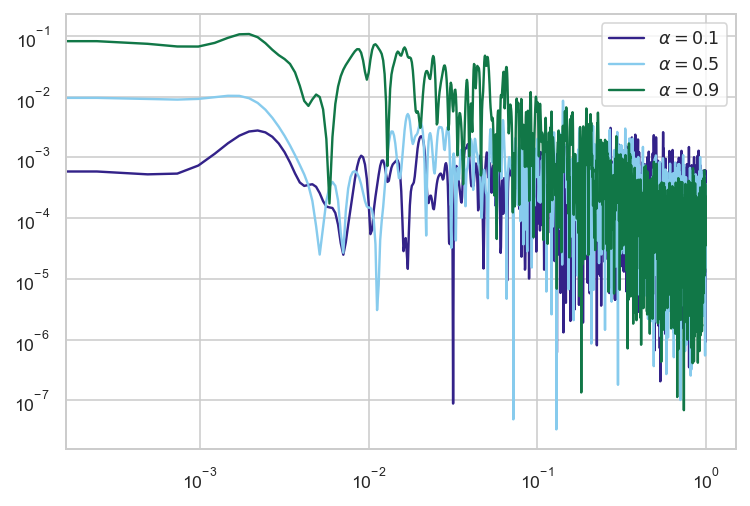

In [30]:
s, f = mlab.psd(y_sml_ar1, NFFT=2**13)
plt.loglog(f, s, label=r'$\alpha=0.1$')

s, f = mlab.psd(y_med_ar1, NFFT=2**13)
plt.loglog(f, s, label=r'$\alpha=0.5$')

s, f = mlab.psd(y_lrg_ar1, NFFT=2**13)
plt.loglog(f, s, label=r'$\alpha=0.9$')
plt.gca().legend()

The plateau at lower frequencies is a consequence of generating a finite red noise time series. The colored noise generator has the advantage of producing spectra for an "infinitely long" red noise process. This is a limitation we will have to live with, as we don't have infinite amounts of data to test against anyways.

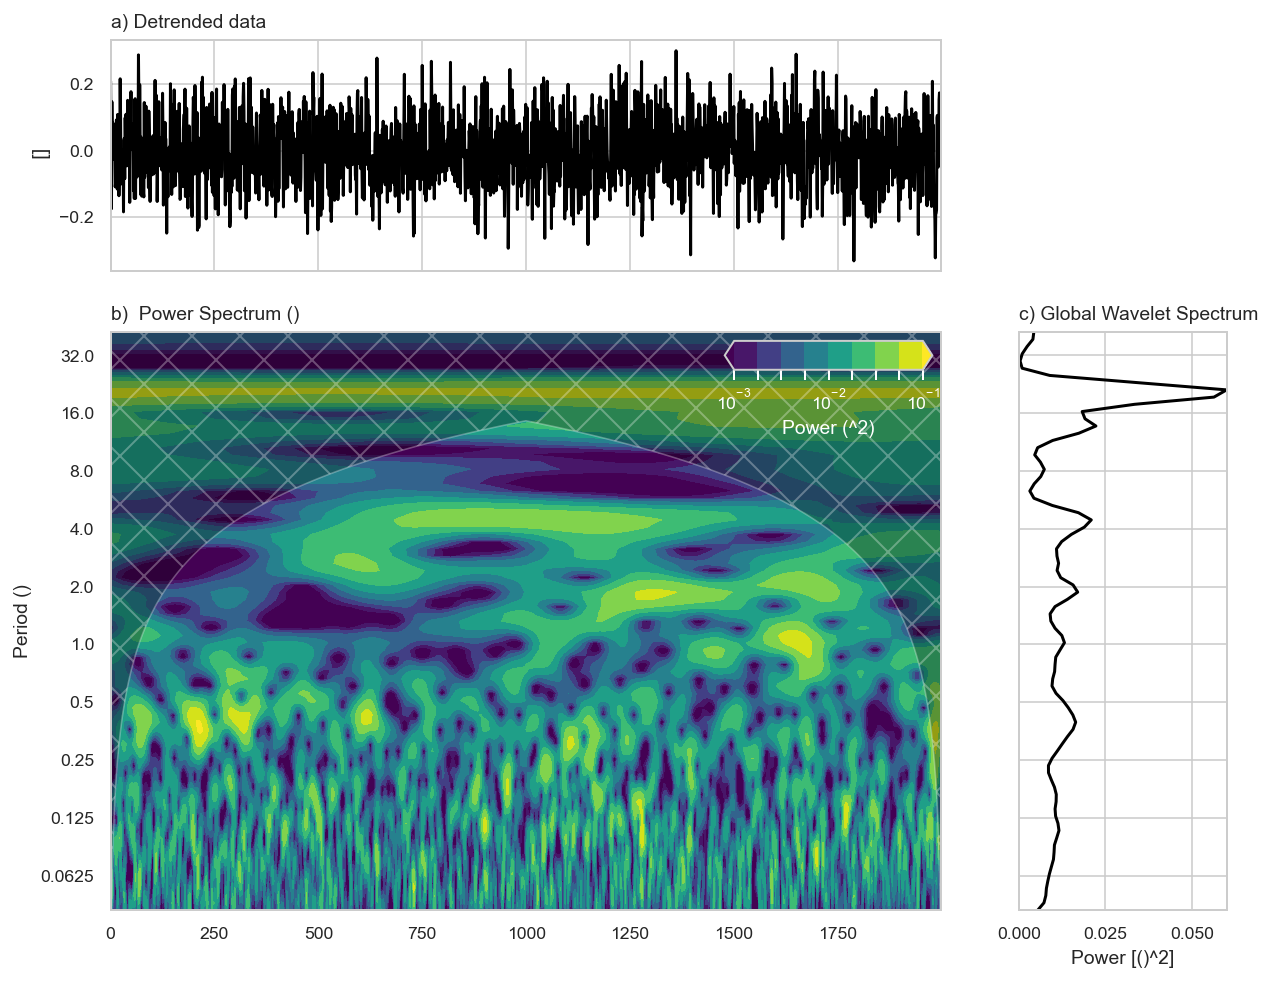

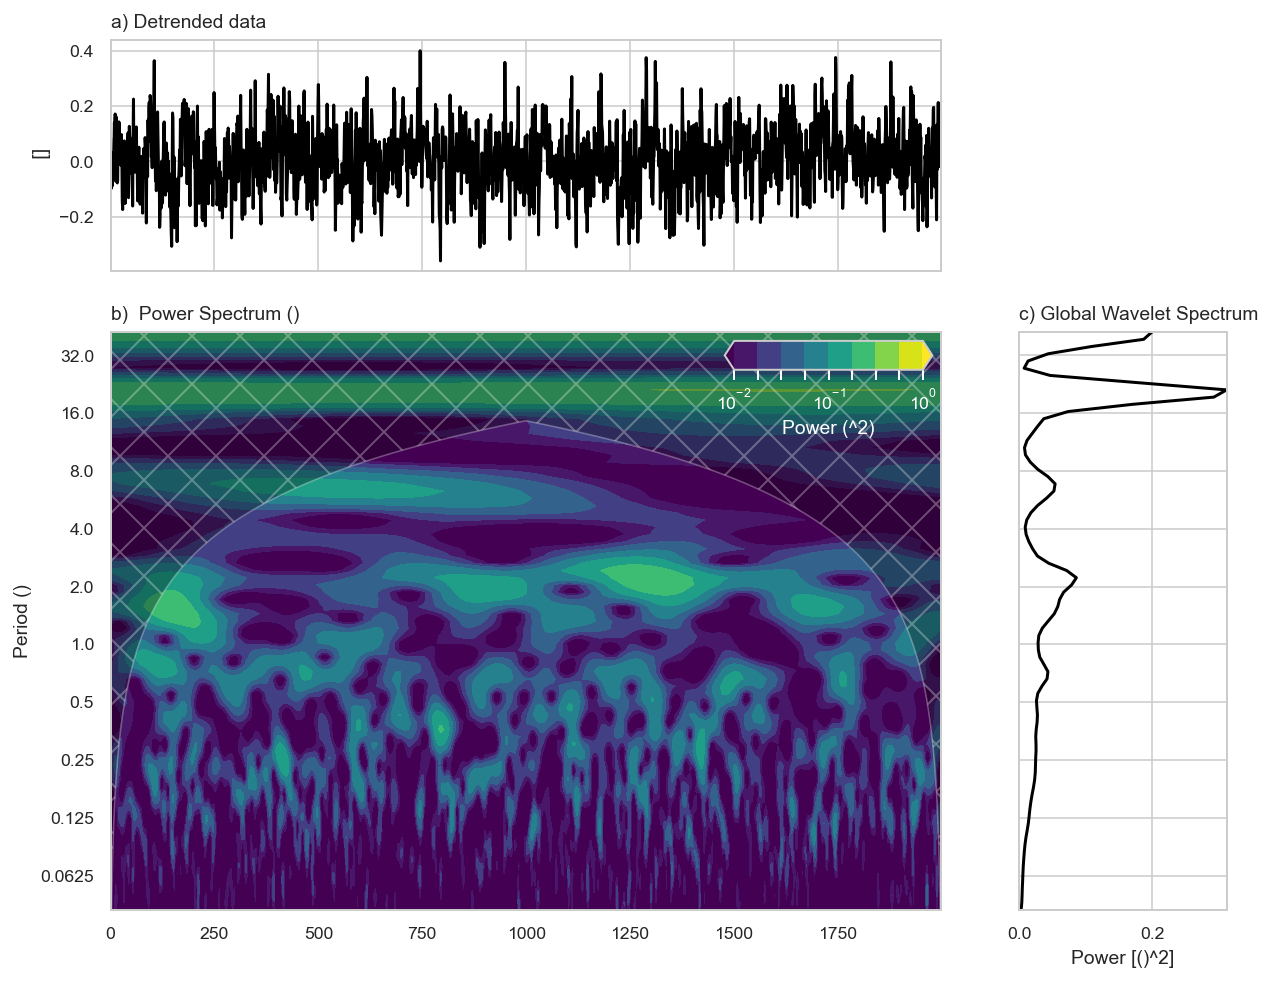

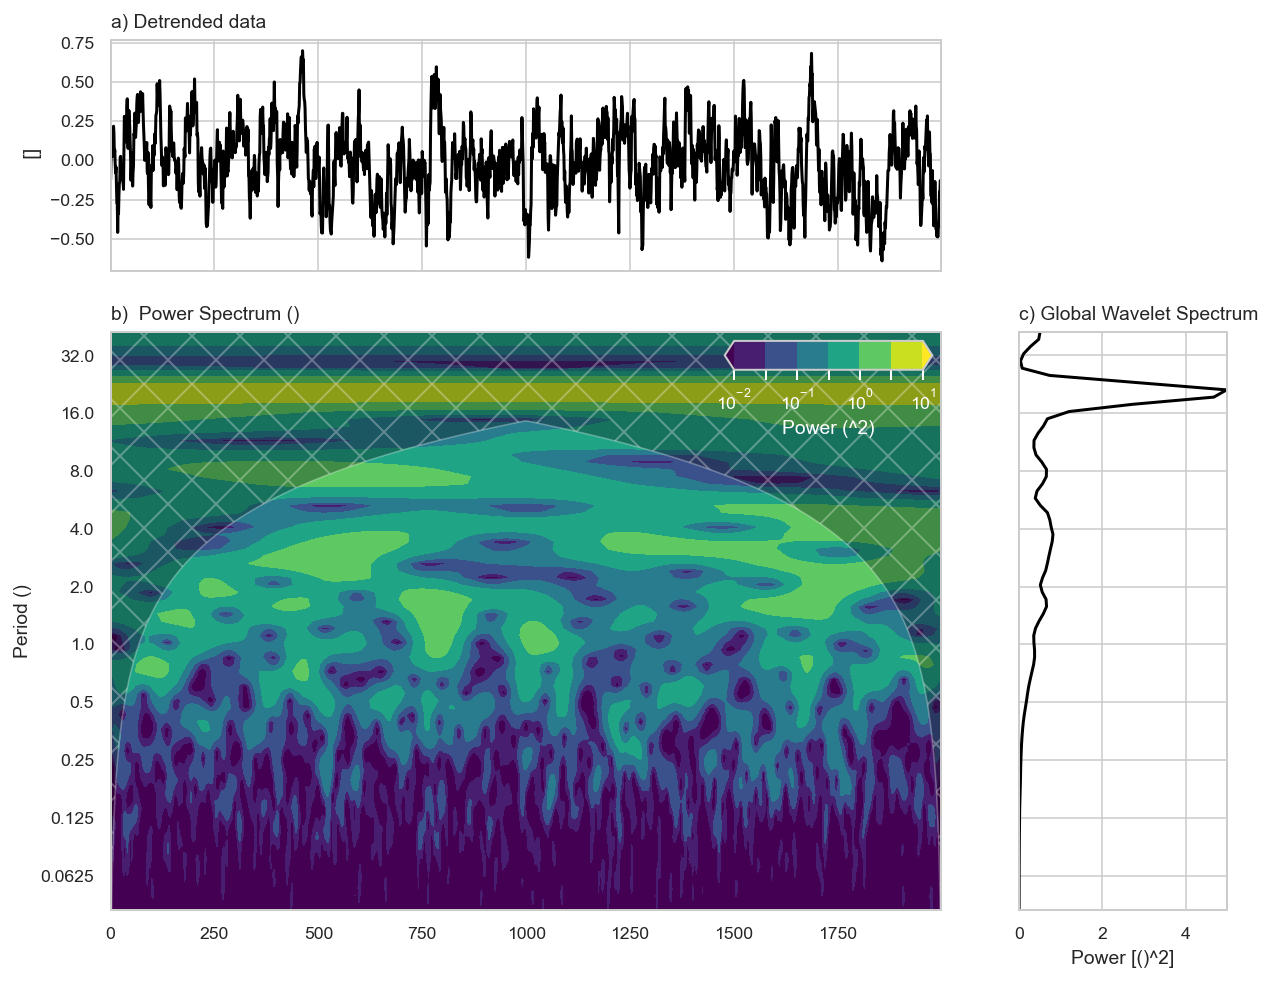

In [31]:
nW1, sj, freq, coi, _, _ = pycwt.cwt(y_sml_ar1, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

nW2, sj, freq, coi, _, _ = pycwt.cwt(y_med_ar1, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

nW3, sj, freq, coi, _, _ = pycwt.cwt(y_lrg_ar1, dt=dt, dj=dj, s0=s0, J=J,
                               wavelet=wavelet)

cwt_plt.plot_wv_power(
    signal_norm=y_sml_ar1,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW1) ** 2,
    coi=coi,
)

cwt_plt.plot_wv_power(
    signal_norm=y_med_ar1,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW2) ** 2,
    coi=coi,
)

cwt_plt.plot_wv_power(
    signal_norm=y_lrg_ar1,
    x=np.arange(N),
    dx=1,
    period=period,
    power=np.abs(nW3) ** 2,
    coi=coi,
)

Ok, so this data generator behaves as expected. The difference between the idealized, theoretically correct red noise (from the colored noise generator) and the actual realization of a lag-1 process is that the idealized time series obeys the properties of an "infinitely long" red noise process. I believe I would need to realize multiple averages of many Markov chains to get the theoretical, smooth spectra for the sloped region of the spectra. We will have to live with the plateau for longer wavelengths. 

## Implementing the brute force lag-1 noise generator in the direct Monte-Carlo results

I will generate two time series

1) For a strongly red noise process ($\alpha$ = 0.9)

2) For a nearly white noise process ($\alpha$ = 0.001)

In [32]:
mc_count = 200
N = 2000
wavelet = mother
significance_level = 0.95
J = np.int(octaves[1])
dj = octaves[0]
dt = sampling_p
s0 = dt * 2
slen = np.int(datalen)

# Red noise MC
al = 0.9
noise = 1 # This is the worst case for the Ultima
sfunc_args1 = [
    al,
    1
]
sfunc_args2 = [
    al,
    1
]

coh_rn, period, scales, coi  = cwt_stat.wct_mc_sig(
    wavelet,
    J,
    dj,
    dt,
    s0,
    sfunc_args1=sfunc_args1,
    sfunc_args2=sfunc_args2,
    mc_count=mc_count,
    slen=N,
    sig_lvl=0.95,
    sfunc=ar1_generator,
)

# White noise MC
al = 0.001
sfunc_args1 = [
    al,
    noise
]
sfunc_args2 = [
    al,
    noise
]

coh_wn, period, scales, coi  = cwt_stat.wct_mc_sig(
    wavelet,
    J,
    dj,
    dt,
    s0,
    sfunc_args1=sfunc_args1,
    sfunc_args2=sfunc_args2,
    mc_count=mc_count,
    slen=N,
    sig_lvl=0.95,
    sfunc=ar1_generator,
)

100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


### Visualize the significance thresholds for these MC results

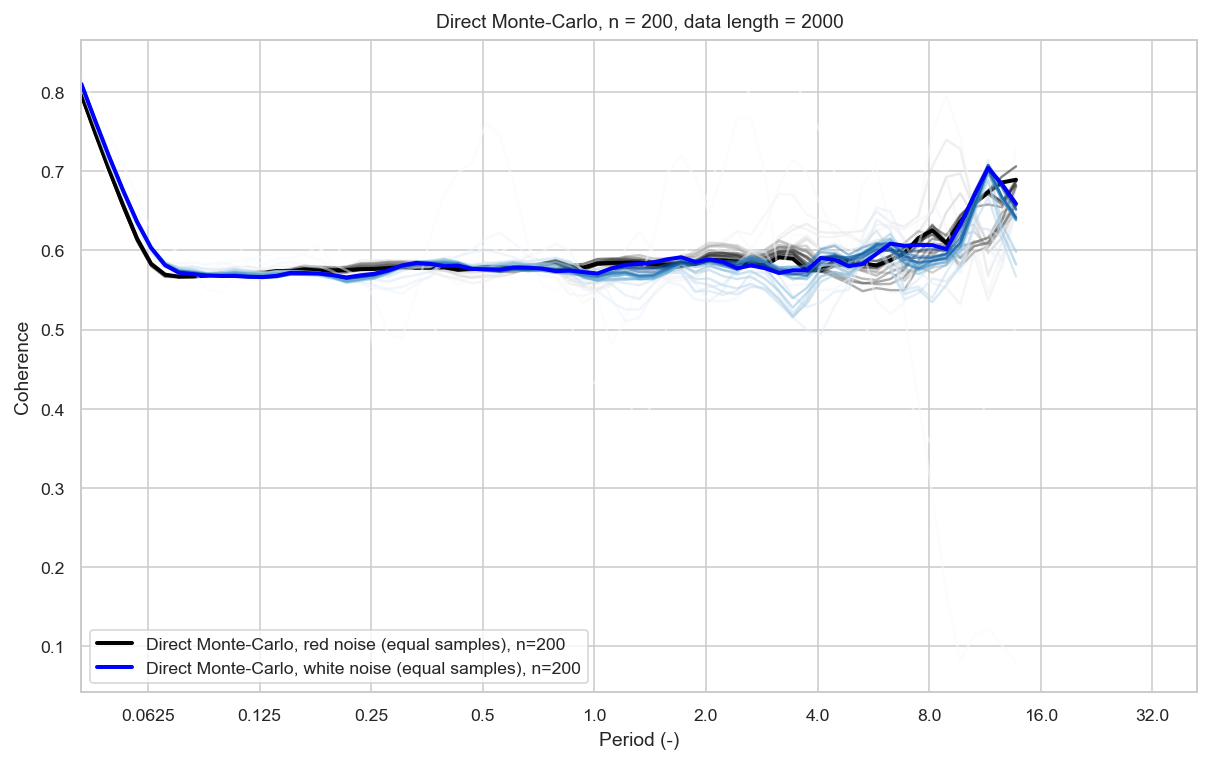

In [33]:
Xticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Red noise
colorseq = plt.cm.Greys(np.linspace(0, 1, mc_count))
slen = N
if mc_count > 60:
    step = 10
else:
    step = 1
for n in np.arange(0, mc_count, step):
    coh_reshape = np.reshape(coh_rn[:, :, :n + 1], (81, slen * (n + 1)))
    ax.plot(
        np.log2(period),
        np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
        color=colorseq[n],
        alpha=0.5,
    )

n = mc_count
# Direct MC: Reduced samples
coh_reshape = np.reshape(coh_rn[:, :, :n+1], (81, slen * n))
ax.plot(
    np.log2(period),
    np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
    color='k',
    lw=2,
    label='Direct Monte-Carlo, red noise (equal samples), n={}'.format(mc_count)
)

# White noise
colorseq = plt.cm.Blues(np.linspace(0, 1, mc_count))
if mc_count > 60:
    step = 10
else:
    step = 1
for n in np.arange(0, mc_count, step):
    coh_reshape = np.reshape(coh_wn[:, :, :n + 1], (81, slen * (n + 1)))
    ax.plot(
        np.log2(period),
        np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
        color=colorseq[n],
        alpha=0.5,
    )

n = mc_count
# Direct MC: Reduced samples
coh_reshape = np.reshape(coh_wn[:, :, :n+1], (81, slen * n))
ax.plot(
    np.log2(period),
    np.nanpercentile(coh_reshape.filled(np.nan), 95, axis=1),
    color='b',
    lw=2,
    label='Direct Monte-Carlo, white noise (equal samples), n={}'.format(mc_count)
)

ax.set_xticks(np.log2(Xticks))
ax.set_xticklabels(Xticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([period.min(), period.max()]))
ax.set_ylabel('Coherence')
ax.set_xlabel('Period (-)')
ax.set_title('Direct Monte-Carlo, n = {}, data length = {}'.format(mc_count, slen))
ax.legend()

Interesting that the coherence spectra is still flat for the biwavelet coherence of two Markov chains. It doesn't matter which color the noise has. This might actually be a novel result!

It makes me more than a little nervous that the level NEVER changes in any of my tests... However, it also correctly identifies the defined signals in the toy data. I have tested a couple permutations including very long MC samples (N = 5000), small white noise vs large white noise, small alpha vs large alpha and found that these have no impact on the results.

Neither TC98 nor TC99 directly address the significance other than plotting a single significance contour for white noise. The red noise null hypothesis was not addressed, so there is some low-hanging fruit here.

# Using the wavelet significance on the toy dataset

In [34]:
# I probably should just return "sig" from the Monte-Carlo simulation.
# But, here is how we can use the entire returned coherence array.
N = 2000
n = mc_count
coh_reshape = np.reshape(coh_rn[:, :, :n+1], (len(period), slen * n))
sig_lvl = np.nanpercentile(coh_reshape.filled(np.nan), 99, axis=1)
sig_lvl = ((np.ones([N, 1]) * np.array(sig_lvl))).T
sig_contour = WCT / sig_lvl

No handles with labels found to put in legend.


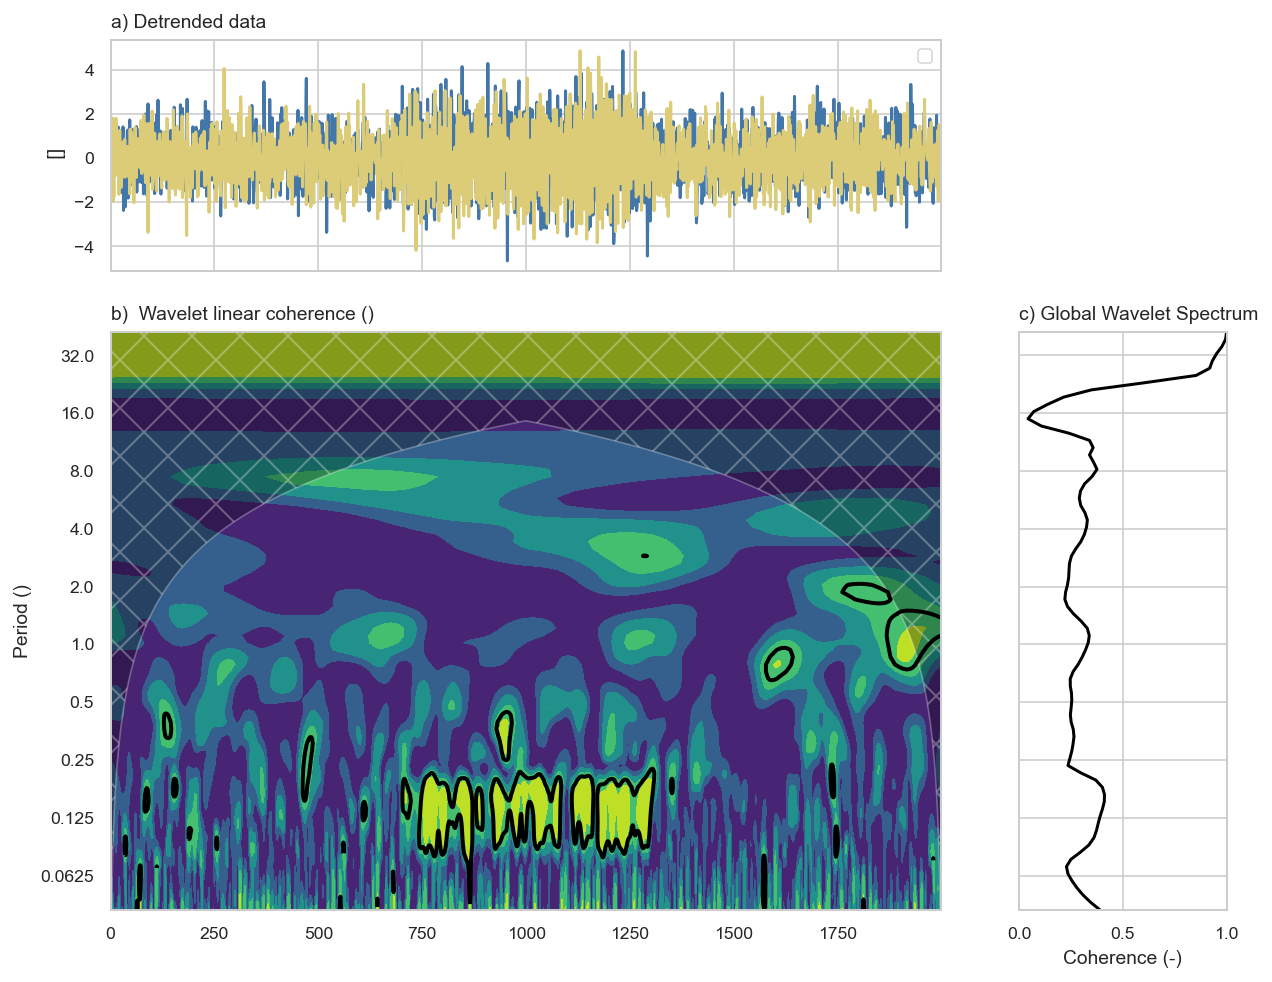

In [35]:
fig_labels = {
    'title': 'Replication of Ge 2008 test case, all',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 's',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': '$\delta t$'
}

cwt_plt.plot_wv_power(
    signal_norm=[x, y],
    x=t,
    dx=sampling_p,
    period=period,
    power=WCT,
    coi=coi_G08,
    levels=np.arange(0, 1.1, 0.2),
    sig95=sig_contour,
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels['title'],
    include_colorbar=False,
    coherence=True
)

Regions inside the black lines are significanct relative to the Monte-Carlo direct simulation. There are a couple spurious coherent sections at longer times, but the built-in coherence is clearly identified.

# Phase Angle

Part of the power of biwavelet coherence is the ability to determine how the phase between the two signals changes with time. I explore that property using the toy data.

The phase arrows in the cross wavelet power spectrum rotate clockwise with 'north' origin. The relative phase relationship convention is the same as adopted by Torrence and Webster (1999), where in phase signals point upwards (N), anti-phase signals point downwards (S). If X leads Y, arrows point to the right (E) and if X lags Y, arrow points to the left (W).

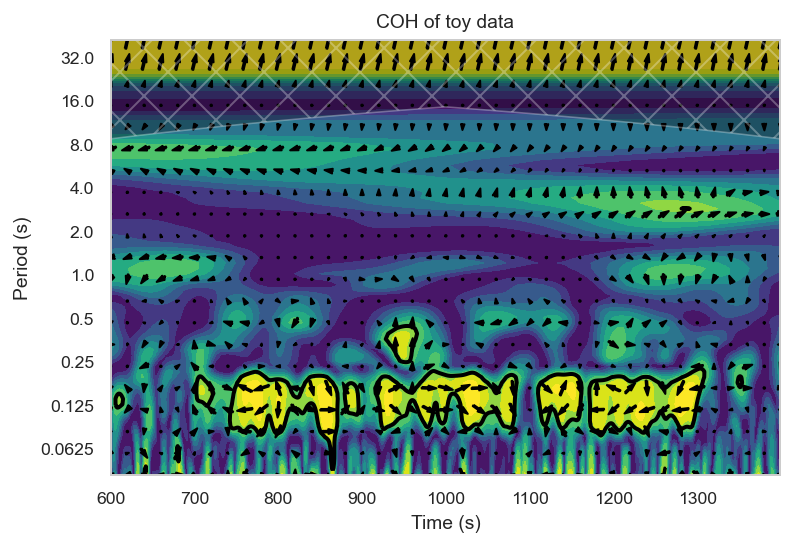

In [36]:
fig, ax = plt.subplots(1, 1,)
cwt_plt.plot_periodogram(
    WCT[:, 600:1400], t[600:1400], dt,
    period, coi=coi[600:1400], ax=ax, sig95=sig_contour[:, 600:1400],
    levels=np.arange(0, 1, 0.1), log_power=False,
)
ax.set_title('COH of toy data')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
u = u * WCT
v = v * WCT

xstep = 20
ystep = 4
ax.quiver(t[::xstep], np.log2(period[::ystep]), u[::ystep, ::xstep], v[::ystep, ::xstep], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k', scale=25)

The arrows are a bit hard to digest. Let's instead plot along only where the coherence is significant and see how that looks.

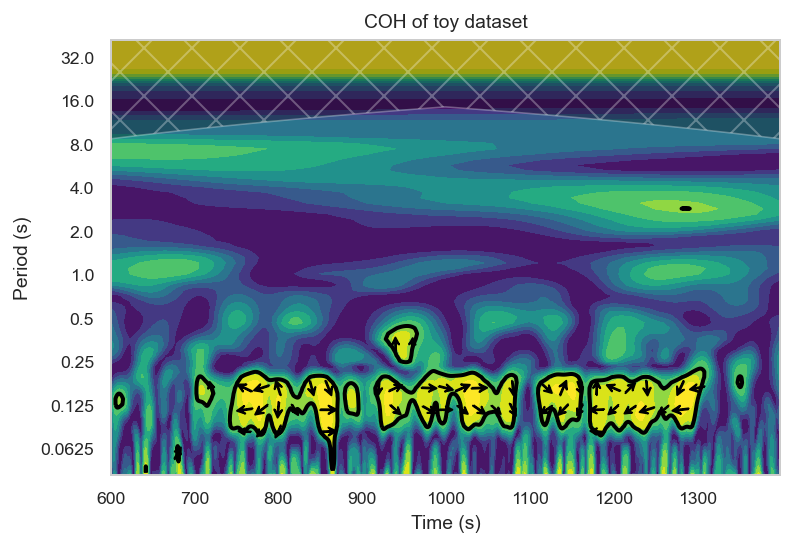

In [37]:
fig, ax = plt.subplots(1, 1,)
cwt_plt.plot_periodogram(
    WCT[:, 600:1400], t[600:1400], dt,
    period, coi=coi[600:1400], ax=ax, sig95=sig_contour[:, 600:1400],
    levels=np.arange(0, 1, 0.1), log_power=False,
)
ax.set_title('COH of toy dataset')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
u = u * WCT
v = v * WCT

xstep = 20
ystep = 4
masked_u = np.ma.array(u, mask=~outside_coi)
masked_v = np.ma.array(v, mask=~outside_coi)
masked_u = np.ma.array(masked_u, mask=sig_contour < 1)
masked_v = np.ma.array(masked_v, mask=sig_contour < 1)
ax.quiver(t[::xstep], np.log2(period[::ystep]), masked_u[::ystep, ::xstep], masked_v[::ystep, ::xstep], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5, scale=25)

Maybe still too dense with the arrows.

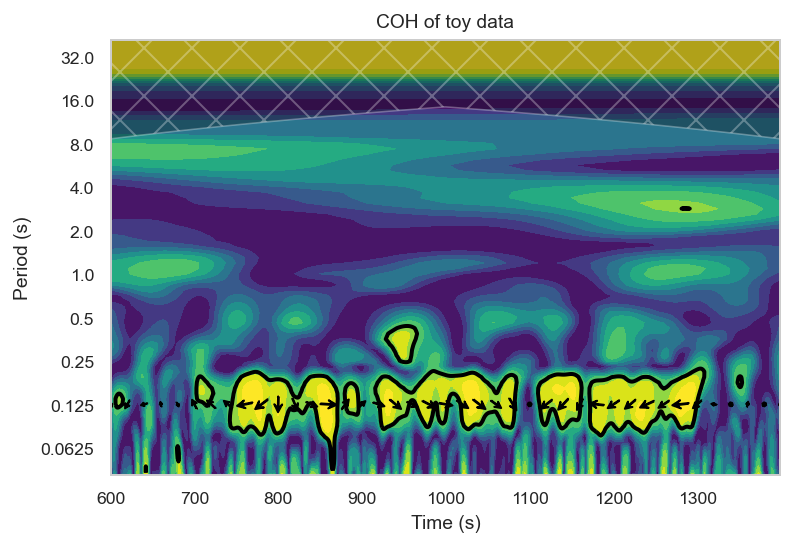

In [38]:
fig, ax = plt.subplots(1, 1,)
cwt_plt.plot_periodogram(
    WCT[:, 600:1400], t[600:1400], dt,
    period, coi=coi[600:1400], ax=ax, sig95=sig_contour[:, 600:1400],
    levels=np.arange(0, 1, 0.1), log_power=False,
)
ax.set_title('COH of toy data')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
u = u * WCT
v = v * WCT

pind = np.flatnonzero(np.abs(period - 1/8) == np.min(np.abs(period - 1/8)))[0]
xstep = 20
ystep = 4
ax.quiver(
    t[::xstep], np.log2(period[pind]), u[pind, ::xstep], v[pind, ::xstep],
    headwidth=10, headlength=10, headaxislength=5, minshaft=2,
    units='height', angles='uv', pivot='mid', linewidth=1, edgecolor='k', scale=25
)



Still a bit hard to digest. What about just plotting the angle directly?

Text(0.5, 0, 'Time (s)')

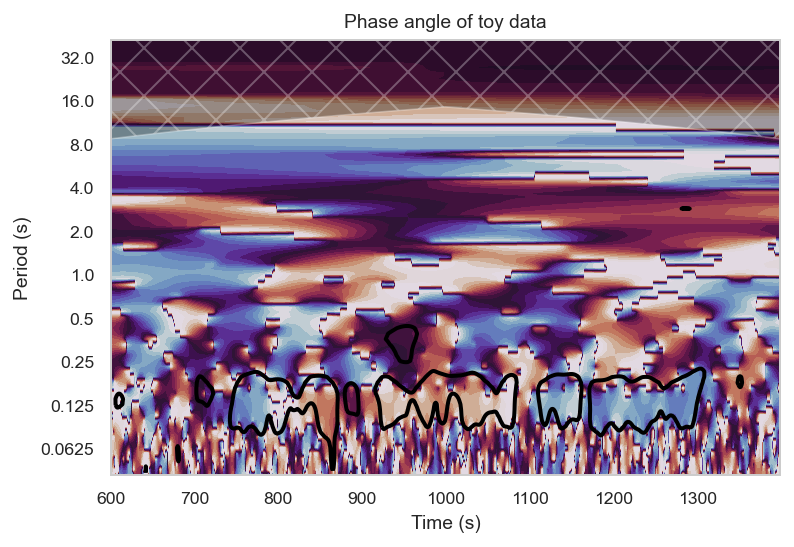

In [39]:
fig, ax = plt.subplots(1, 1,)
cwt_plt.plot_periodogram(
    aWCT[:, 600:1400], t[600:1400], dt,
    period, coi=coi[600:1400], ax=ax, sig95=sig_contour[:, 600:1400],
    levels=np.arange(-3, 3, 0.25), log_power=False, cmap='twilight'
)
ax.set_title('Phase angle of toy data')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
# angle = 0.5 * np.pi - aWCT


And then just selecting for a particular frequency windo and plotting the time series.

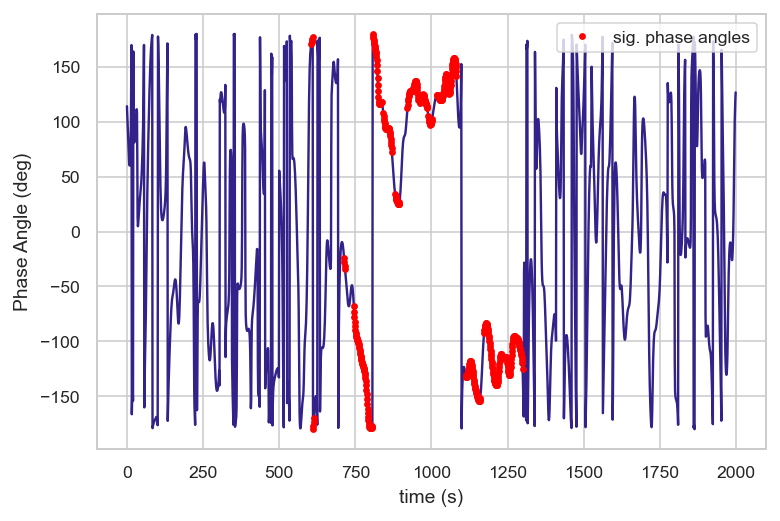

In [40]:
plt.plot(t, aWCT[pind, :] * 180 / np.pi)
plt.plot(
    t[sig_contour[pind] > 1],
    aWCT[pind, sig_contour[pind] > 1] * 180 / np.pi,
    color='r', marker='.', ls='None', lw=2, label='sig. phase angles')
plt.gca().set_ylabel('Phase Angle (deg)')
plt.gca().set_xlabel('time (s)')
plt.gca().legend(loc='upper right')

And this is exactly what we programmed into the toy data set (minus any extra little spurious points). In regime 1 the phase angle linearly changes. In regime 2 the phase angle is constant with x leading y. In regime 3 the phase angle is constant with y leading x.

For phase relationships it is critical to visualize the results using appropriate slices of the data, otherwise noise can make visual inspection nearly impossible.